In [73]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime as dt
from datetime import date, timedelta
import plotly.graph_objects as go
import plotly.express as px
import plotly.subplots as sp
import statsmodels.api as sm
from plotly.subplots import make_subplots
import itertools
import requests
import yfinance as yf
from datetime import datetime, timedelta
from IPython.display import Image, display
from matplotlib import cm
from fredapi import Fred


### Partie 1: Téléchargement des bases de données trimestrielle du CPI, GDP et Taux d'intérét

In [32]:
api_key = "8e877013bcb3862ac90cd864024bdb75"

def download_fred_data(series_id, start_date, end_date):
    url = f"https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&observation_start={start_date}&observation_end={end_date}&file_type=json"
    response = requests.get(url)
    data = response.json()
    df = pd.DataFrame(data['observations'])
    df['date'] = pd.to_datetime(df['date'])
    df[series_id] = pd.to_numeric(df['value'], errors='coerce')
    df = df[['date', series_id]]
    df.set_index('date', inplace=True)
    return df

gdp_data = download_fred_data("GDPC1", "2000-01-01", "2025-12-31")
inflation_data = download_fred_data("CPIAUCNS", "2000-01-01", "2025-12-31")
interest_rate_data = download_fred_data("FEDFUNDS","2000-01-01", "2025-12-31")

gdp_data['GDPC1'] = pd.to_numeric(gdp_data['GDPC1'], errors='coerce')
inflation_data['CPIAUCNS'] = pd.to_numeric(inflation_data['CPIAUCNS'], errors='coerce')
interest_rate_data['FEDFUNDS'] = pd.to_numeric(interest_rate_data['FEDFUNDS'], errors='coerce')

gdp_data.reset_index(inplace=True)

inflation_data.insert(0,"Date",inflation_data.index,True)
inflation_data["Date"]=inflation_data.index
inflation_data.reset_index(drop=True, inplace=True)
inflation_data['date'] = pd.to_datetime(inflation_data['Date'])
inflation_data['Quarter'] = inflation_data['date'].dt.to_period('Q')
inflation_data_quarterly = inflation_data.groupby('Quarter').mean().reset_index()
premiere_dates_trimestre = inflation_data.groupby('Quarter')['date'].first().reset_index()
inflation_data_quarterly['date'] = premiere_dates_trimestre['date']
inflation_data_quarterly = inflation_data_quarterly.reindex(columns=['date', 'CPIAUCNS'])

interest_rate_data.insert(0,"date",interest_rate_data.index,True)
interest_rate_data["date"]=interest_rate_data.index
interest_rate_data.reset_index(drop=True, inplace=True)
interest_rate_data['date'] = pd.to_datetime(interest_rate_data['date'])
interest_rate_data['Quarter'] = interest_rate_data['date'].dt.to_period('Q')
interest_rate_data_quarterly = interest_rate_data.groupby('Quarter').mean().reset_index()
premiere_dates_trimestre = interest_rate_data.groupby('Quarter')['date'].first().reset_index()
interest_rate_data_quarterly['date'] = premiere_dates_trimestre['date']
interest_rate_data_quarterly = interest_rate_data_quarterly.reindex(columns=['date', 'FEDFUNDS'])

inflation_data_quarterly['Inflation_Growth_Rate'] = inflation_data_quarterly['CPIAUCNS'].pct_change()
inflation_data_quarterly['Previous_Inflation_Growth_Rate'] = inflation_data_quarterly['Inflation_Growth_Rate'].shift(1)

gdp_data['GDP_Growth_Rate'] = gdp_data['GDPC1'].pct_change()
gdp_data['Previous_GDP_Growth_Rate'] = gdp_data['GDP_Growth_Rate'].shift(1)

interest_rate_data_quarterly['FEDFUNDS_Growth_Rate'] = interest_rate_data_quarterly['FEDFUNDS'].pct_change()
interest_rate_data_quarterly['Previous_FEDFUNDS_Growth_Rate'] = interest_rate_data_quarterly['FEDFUNDS_Growth_Rate'].shift(1)

merged_data = pd.merge(gdp_data, inflation_data_quarterly, on='date')
merged_data = pd.merge(merged_data, interest_rate_data_quarterly, on='date')

merged_data_rate = merged_data.drop(columns=['Previous_GDP_Growth_Rate', 'Previous_Inflation_Growth_Rate', 'Previous_FEDFUNDS_Growth_Rate'])
merged_data_rate

date      GDPC1  GDP_Growth_Rate    CPIAUCNS  Inflation_Growth_Rate  \
0   2000-01-01  13878.147              NaN  169.933333                    NaN   
1   2000-04-01  14130.908         0.018213  171.733333               0.010592   
2   2000-07-01  14145.312         0.001019  173.100000               0.007958   
3   2000-10-01  14229.765         0.005970  174.033333               0.005392   
4   2001-01-01  14183.120        -0.003278  175.700000               0.009577   
..         ...        ...              ...         ...                    ...   
97  2024-04-01  23286.508         0.008855  313.930667               0.011510   
98  2024-07-01  23478.570         0.008248  314.879000               0.003021   
99  2024-10-01  23586.542         0.004599  315.587333               0.002250   
100 2025-01-01  23548.210        -0.001625  318.850667               0.010341   
101 2025-04-01  23770.976         0.009460  321.607000               0.008645   

     FEDFUNDS  FEDFUNDS_Growth_Rate  
0    5.676667                   NaN  
1    6.273333              0.105109  
2    6.520000              0.039320  
3    6.473333             -0.007157  
4    5.593333             -0.135942  
..        ...                   ...  
97   5.330000              0.000000  
98   5.263333             -0.012508  
99   4.650000             -0.116529  
100  4.330000             -0.068817  
101  4.330000              0.000000  

[102 rows x 7 columns]

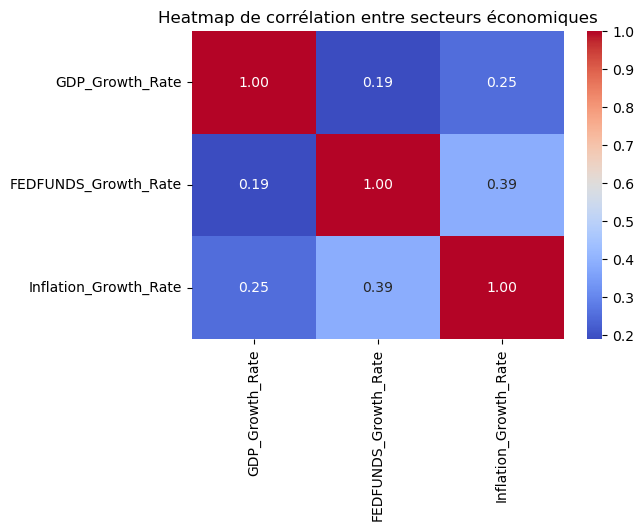

In [33]:
correlation_matrix = merged_data[['GDP_Growth_Rate', 'FEDFUNDS_Growth_Rate', 'Inflation_Growth_Rate']].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap de corrélation entre secteurs économiques')
plt.show()

### Partie 2: Analyse du comportement du GDP et du Taux d'intérét en fonction des scénarios de variabilité du CPI

**Scénarios traités pour CPI: Hyperinflation, Déflation, Stagflation, Inflation élevée, Inflation modérée, Désinflation et Reprise après Déflation**

In [34]:
def assign_scenario(row):
    inflation_growth_rate = row['Inflation_Growth_Rate']
    previous_inflation_growth_rate = row['Previous_Inflation_Growth_Rate']

    if inflation_growth_rate >= 0.5:
        scenario = "Hyperinflation"
    elif inflation_growth_rate < -0.02 and inflation_growth_rate < previous_inflation_growth_rate:
        scenario = "Déflation"
    elif inflation_growth_rate > 0.05 and inflation_growth_rate > previous_inflation_growth_rate:
        scenario = "Stagflation"
    elif 0.02 < inflation_growth_rate <= 0.05 and inflation_growth_rate > previous_inflation_growth_rate:
        scenario = "Inflation élevée"
    elif -0.02 <= inflation_growth_rate <= 0.02 and inflation_growth_rate > previous_inflation_growth_rate:
        scenario = "Inflation modérée"
    elif inflation_growth_rate < previous_inflation_growth_rate:
        scenario = "Désinflation"
    elif inflation_growth_rate < -0.02 and inflation_growth_rate > previous_inflation_growth_rate:
        scenario = "Reprise après Déflation"
    else:
        scenario = None
    return scenario

merged_data['Scenario'] = merged_data.apply(assign_scenario, axis=1)

scenario_data = merged_data[['date', 'Scenario']].dropna()
scenario_data

date           Scenario
2   2000-07-01       Désinflation
3   2000-10-01       Désinflation
4   2001-01-01  Inflation modérée
5   2001-04-01  Inflation modérée
6   2001-07-01       Désinflation
..         ...                ...
97  2024-04-01  Inflation modérée
98  2024-07-01       Désinflation
99  2024-10-01       Désinflation
100 2025-01-01  Inflation modérée
101 2025-04-01       Désinflation

[100 rows x 2 columns]

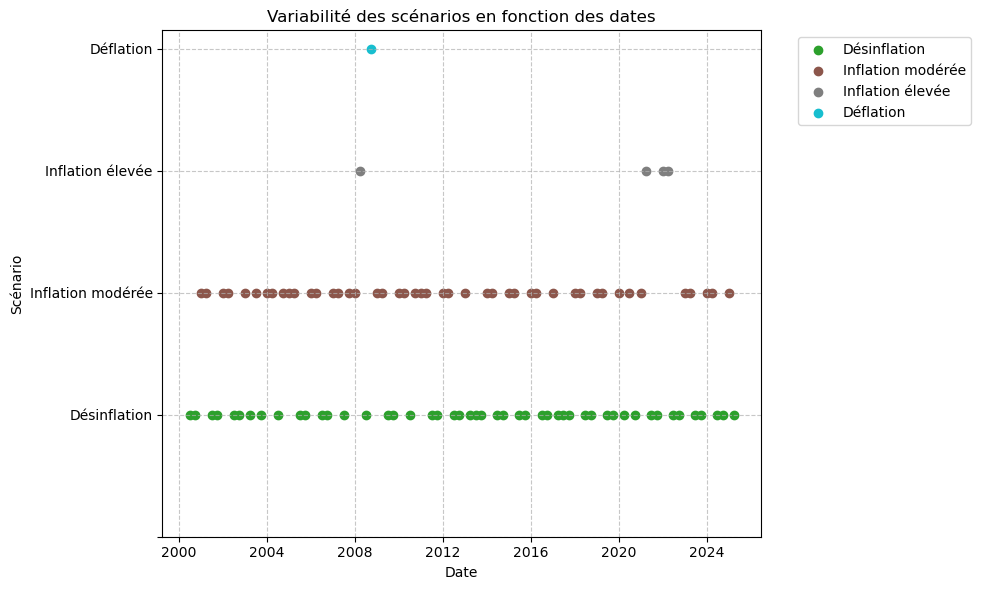

In [35]:
growth_rate = merged_data.drop(columns=['GDPC1', 'CPIAUCNS', 'FEDFUNDS', 'Previous_GDP_Growth_Rate', 'Previous_Inflation_Growth_Rate', 'Previous_FEDFUNDS_Growth_Rate'])

plt.figure(figsize=(10, 6))

unique_scenarios = growth_rate['Scenario'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_scenarios)))

for i, scenario in enumerate(unique_scenarios):
    scenario_data_subset = growth_rate[growth_rate['Scenario'] == scenario]
    plt.scatter(scenario_data_subset['date'], [i] * len(scenario_data_subset), color=colors[i], label=scenario)

plt.title('Variabilité des scénarios en fonction des dates')
plt.xlabel('Date')
plt.ylabel('Scénario')

plt.xticks(rotation=0, ha='center')

plt.yticks(np.arange(len(unique_scenarios)), unique_scenarios)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

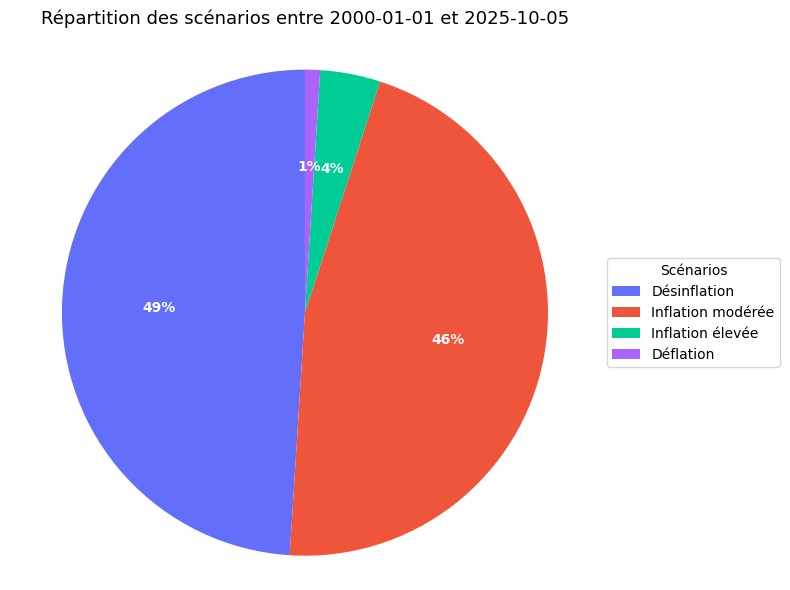

In [36]:
start_date = '2000-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

filtered_data = merged_data[
    (merged_data['date'] >= start_date) &
    (merged_data['date'] <= end_date)
]

scenario_counts = filtered_data['Scenario'].value_counts().reset_index()
scenario_counts.columns = ['Scenario', 'Count']

colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#19D3F3', '#FF97FF','#B6E880']

fig, ax = plt.subplots(figsize=(8, 6))

wedges, texts, autotexts = ax.pie(
    scenario_counts['Count'],
    labels=None,  
    autopct='%1.0f%%',
    startangle=90,
    colors=colors[:len(scenario_counts)],  
    textprops={'color': 'white', 'fontsize': 10, 'weight': 'bold'}
)

ax.legend(
    wedges,
    scenario_counts['Scenario'],
    title="Scénarios",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),
    fontsize=10
)

plt.title(f"Répartition des scénarios entre {start_date} et {end_date}", fontsize=13, pad=15)
ax.axis('equal')

plt.tight_layout()
plt.show()


In [37]:
merged_all_data_encoded = pd.get_dummies(scenario_data, columns=['Scenario'])
merged_all_data_encoded_no_date = merged_all_data_encoded.drop(columns='date')

growth_rate_reset = growth_rate.reset_index(drop=True)

final_data_for_corr = pd.concat(
    [merged_all_data_encoded_no_date,
     growth_rate_reset[['GDP_Growth_Rate', 'FEDFUNDS_Growth_Rate', 'Inflation_Growth_Rate']]],
    axis=1
)

correlation = final_data_for_corr.corr()
correlation = correlation.loc[
    ['GDP_Growth_Rate', 'FEDFUNDS_Growth_Rate', 'Inflation_Growth_Rate'],
    [col for col in correlation.columns if 'Scenario_' in col]
]

correlation

Scenario_Déflation  Scenario_Désinflation  \
GDP_Growth_Rate                 -0.217740              -0.060385   
FEDFUNDS_Growth_Rate            -0.133167              -0.093822   
Inflation_Growth_Rate           -0.466482              -0.394839   

                       Scenario_Inflation modérée  Scenario_Inflation élevée  
GDP_Growth_Rate                          0.102733                   0.003316  
FEDFUNDS_Growth_Rate                    -0.041041                   0.411341  
Inflation_Growth_Rate                    0.293683                   0.497163

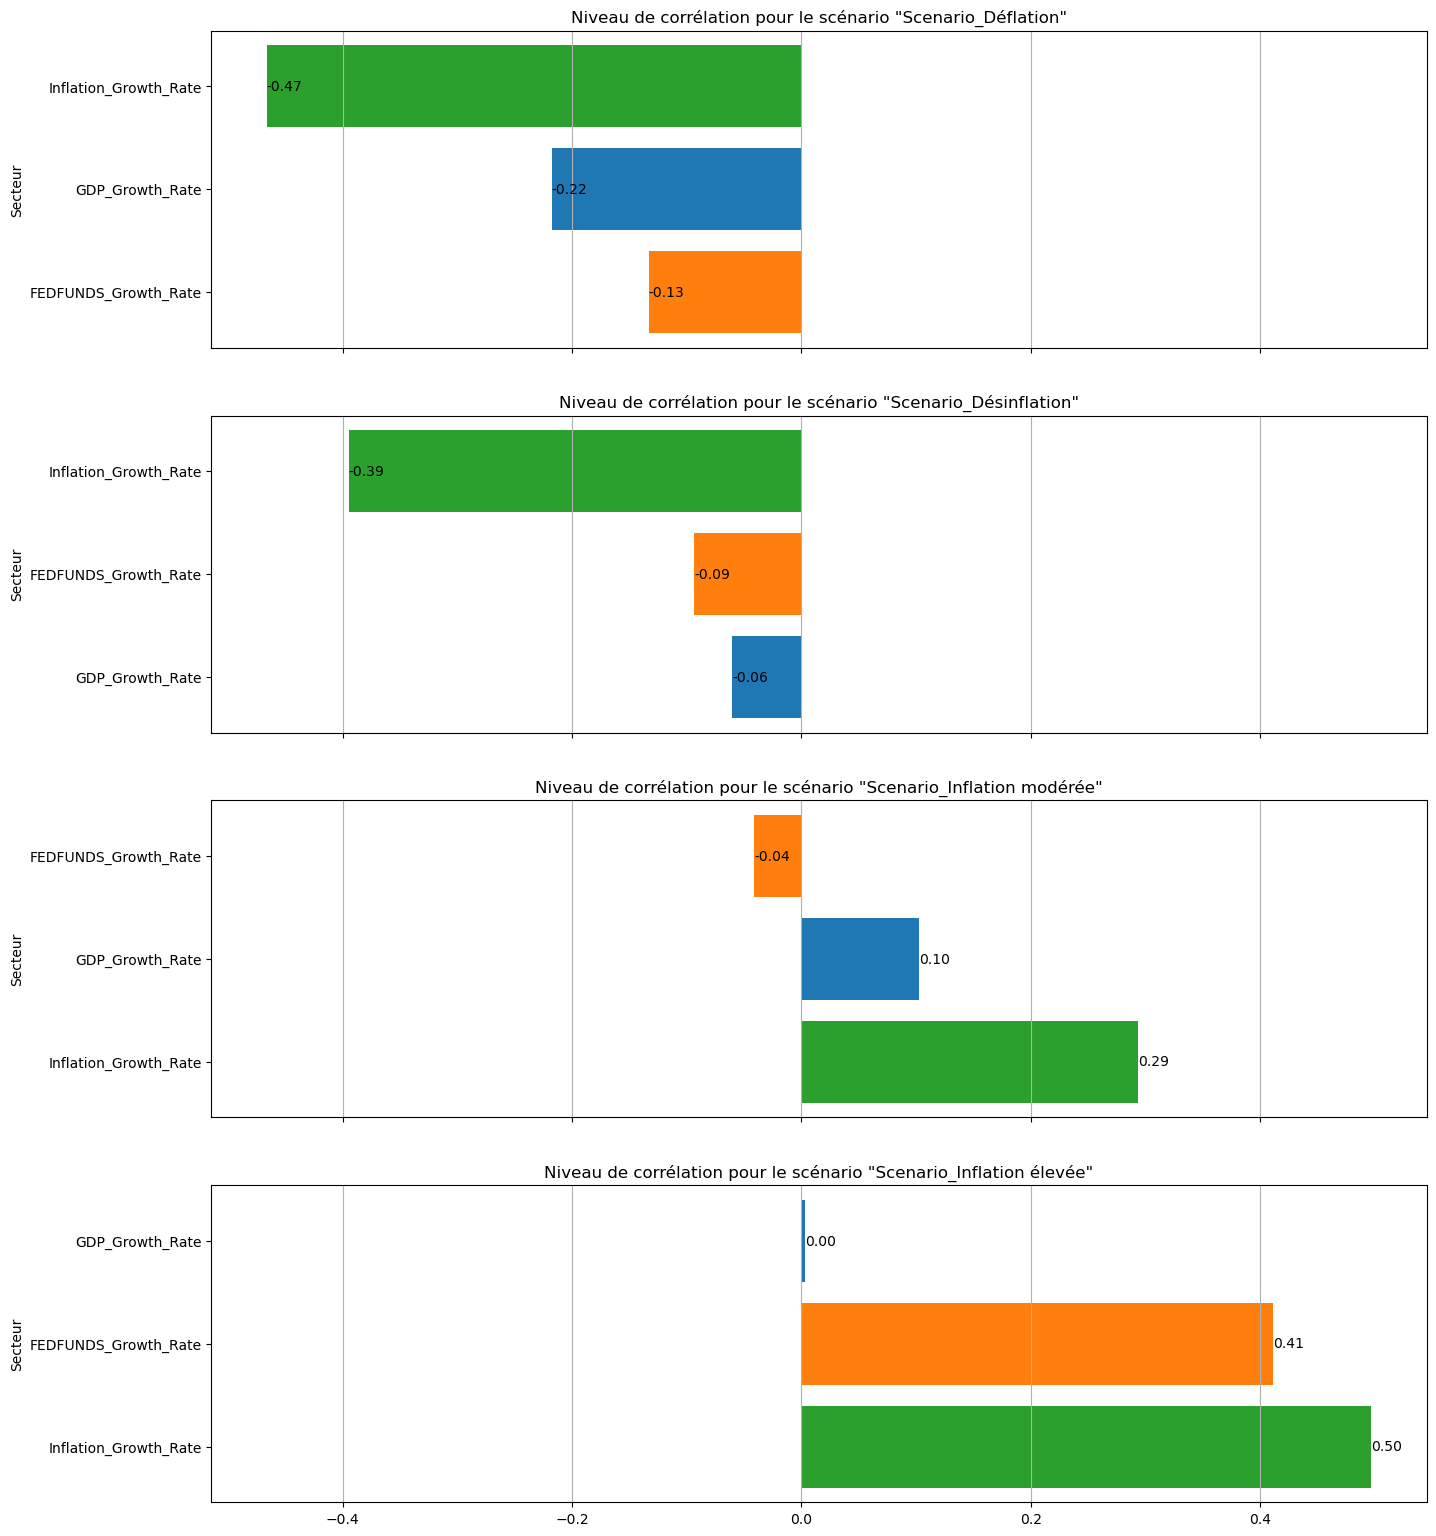

In [38]:
total_scenarios = len(correlation.columns)

sector_color_dict = {}
colors = plt.cm.tab10.colors[:len(correlation.index)]
for i, sector in enumerate(correlation.index):
    sector_color_dict[sector] = colors[i]

fig, axes = plt.subplots(total_scenarios, 1, figsize=(15, total_scenarios*4), sharex=True)

for i, scenario in enumerate(correlation.columns):
    sorted_sectors = correlation[scenario].sort_values(ascending=False)

    ax = axes[i]
    sectors = sorted_sectors.index
    scores = sorted_sectors.values

    colors = [sector_color_dict[sector] for sector in sectors]

    ax.barh(sectors, scores, color=colors)

    ax.set_ylabel('Secteur')
    ax.set_title(f'Niveau de corrélation pour le scénario "{scenario}"')
    ax.grid(axis='x')

    for j, score in enumerate(scores):
        ax.text(score, j, f'{score:.2f}', ha='left', va='center')

plt.tight_layout(pad=3.0)
plt.show()

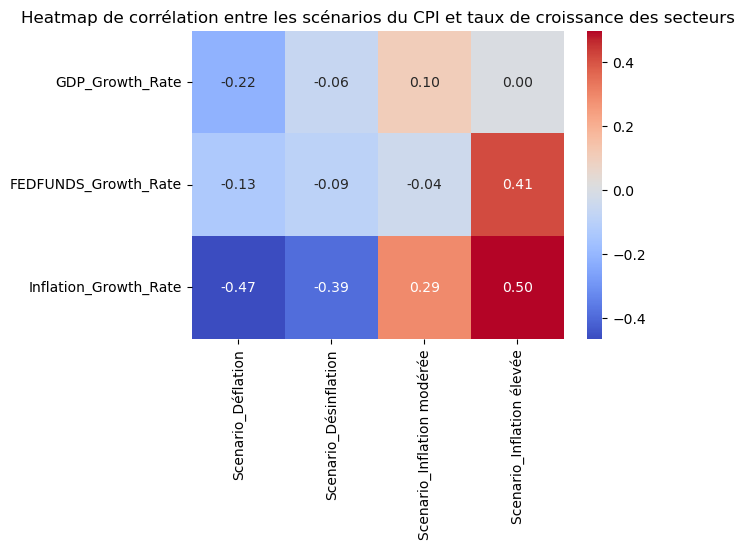

In [39]:
plt.figure(figsize=(6, 4))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap de corrélation entre les scénarios du CPI et taux de croissance des secteurs')
plt.show()

### Partie 3: Analyse du comportement du CPI et du Taux d'intérét en fonction des scénarios de variabilité du GDP

**Scénarios traités pour GDP: Expansion économique, Récession économique, Ralentissement économique, Recouvrement économique**

In [40]:
def assign_scenario(row):
    GDP_Growth_Rate = row['GDP_Growth_Rate']
    Previous_GDP_Growth_Rate = row['Previous_GDP_Growth_Rate']

    if GDP_Growth_Rate > 0 and GDP_Growth_Rate > Previous_GDP_Growth_Rate:
        scenario = "Expansion économique"
    elif GDP_Growth_Rate < 0 and GDP_Growth_Rate < Previous_GDP_Growth_Rate:
        scenario = "Récession économique"
    elif GDP_Growth_Rate > 0 and GDP_Growth_Rate < Previous_GDP_Growth_Rate:
        scenario = "Ralentissement économique"
    elif GDP_Growth_Rate < 0 and GDP_Growth_Rate > Previous_GDP_Growth_Rate:
        scenario = "Recouvrement économique"
    else:
        scenario = None
    return scenario

merged_data['Scenario'] = merged_data.apply(assign_scenario, axis=1)

scenario_data = merged_data[['date', 'Scenario']].dropna()
scenario_data

date                   Scenario
2   2000-07-01  Ralentissement économique
3   2000-10-01       Expansion économique
4   2001-01-01       Récession économique
5   2001-04-01       Expansion économique
6   2001-07-01       Récession économique
..         ...                        ...
97  2024-04-01       Expansion économique
98  2024-07-01  Ralentissement économique
99  2024-10-01  Ralentissement économique
100 2025-01-01       Récession économique
101 2025-04-01       Expansion économique

[100 rows x 2 columns]

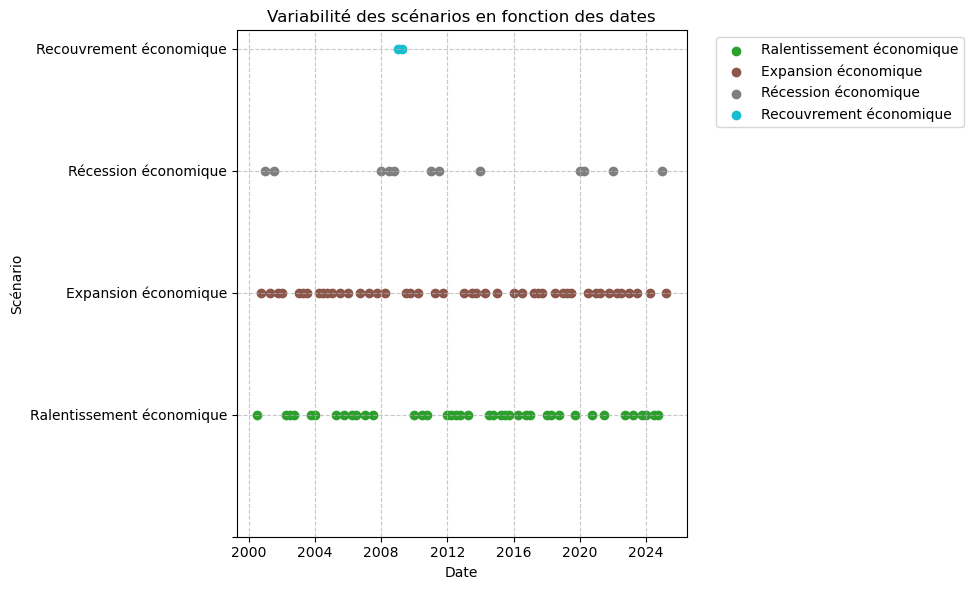

In [41]:
growth_rate = merged_data.drop(columns=['GDPC1', 'CPIAUCNS', 'FEDFUNDS', 'Previous_GDP_Growth_Rate', 'Previous_Inflation_Growth_Rate', 'Previous_FEDFUNDS_Growth_Rate'])

plt.figure(figsize=(10, 6))

unique_scenarios = growth_rate['Scenario'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_scenarios)))

for i, scenario in enumerate(unique_scenarios):
    scenario_data_subset = growth_rate[growth_rate['Scenario'] == scenario]
    plt.scatter(scenario_data_subset['date'], [i] * len(scenario_data_subset), color=colors[i], label=scenario)

plt.title('Variabilité des scénarios en fonction des dates')
plt.xlabel('Date')
plt.ylabel('Scénario')

plt.xticks(rotation=0, ha='center')

plt.yticks(np.arange(len(unique_scenarios)), unique_scenarios)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

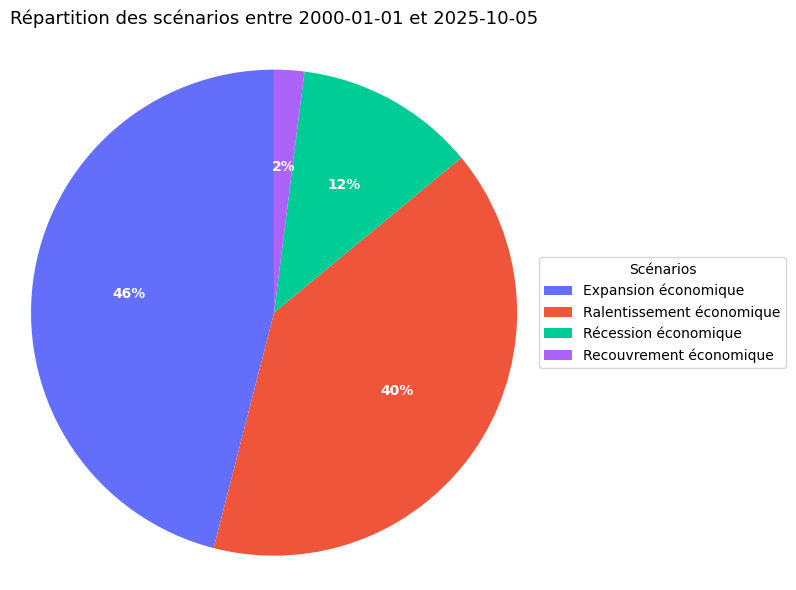

In [42]:
start_date = '2000-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

filtered_data = merged_data[
    (merged_data['date'] >= start_date) &
    (merged_data['date'] <= end_date)
]

scenario_counts = filtered_data['Scenario'].value_counts().reset_index()
scenario_counts.columns = ['Scenario', 'Count']

colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#19D3F3', '#FF97FF','#B6E880']

fig, ax = plt.subplots(figsize=(8, 6))

wedges, texts, autotexts = ax.pie(
    scenario_counts['Count'],
    labels=None,  
    autopct='%1.0f%%',
    startangle=90,
    colors=colors[:len(scenario_counts)],  
    textprops={'color': 'white', 'fontsize': 10, 'weight': 'bold'}
)

ax.legend(
    wedges,
    scenario_counts['Scenario'],
    title="Scénarios",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),
    fontsize=10
)

plt.title(f"Répartition des scénarios entre {start_date} et {end_date}", fontsize=13, pad=15)
ax.axis('equal')

plt.tight_layout()
plt.show()


In [43]:
merged_all_data_encoded = pd.get_dummies(scenario_data, columns=['Scenario'])

merged_all_data_encoded_no_date = merged_all_data_encoded.drop(columns='date')

growth_rate_reset = growth_rate.reset_index(drop=True)

final_data_for_corr = pd.concat(
    [merged_all_data_encoded_no_date,
     growth_rate_reset[['GDP_Growth_Rate', 'FEDFUNDS_Growth_Rate', 'Inflation_Growth_Rate']]],
    axis=1
)

correlation = final_data_for_corr.corr()

correlation = correlation.loc[
    ['GDP_Growth_Rate', 'FEDFUNDS_Growth_Rate', 'Inflation_Growth_Rate'],
    [col for col in correlation.columns if 'Scenario_' in col and 'Autres' not in col]
]

correlation

Scenario_Expansion économique  \
GDP_Growth_Rate                             0.368032   
FEDFUNDS_Growth_Rate                        0.152451   
Inflation_Growth_Rate                       0.150165   

                       Scenario_Ralentissement économique  \
GDP_Growth_Rate                                 -0.003353   
FEDFUNDS_Growth_Rate                            -0.006230   
Inflation_Growth_Rate                           -0.095407   

                       Scenario_Recouvrement économique  \
GDP_Growth_Rate                               -0.135046   
FEDFUNDS_Growth_Rate                          -0.096017   
Inflation_Growth_Rate                         -0.067212   

                       Scenario_Récession économique  
GDP_Growth_Rate                            -0.501220  
FEDFUNDS_Growth_Rate                       -0.183058  
Inflation_Growth_Rate                      -0.057521

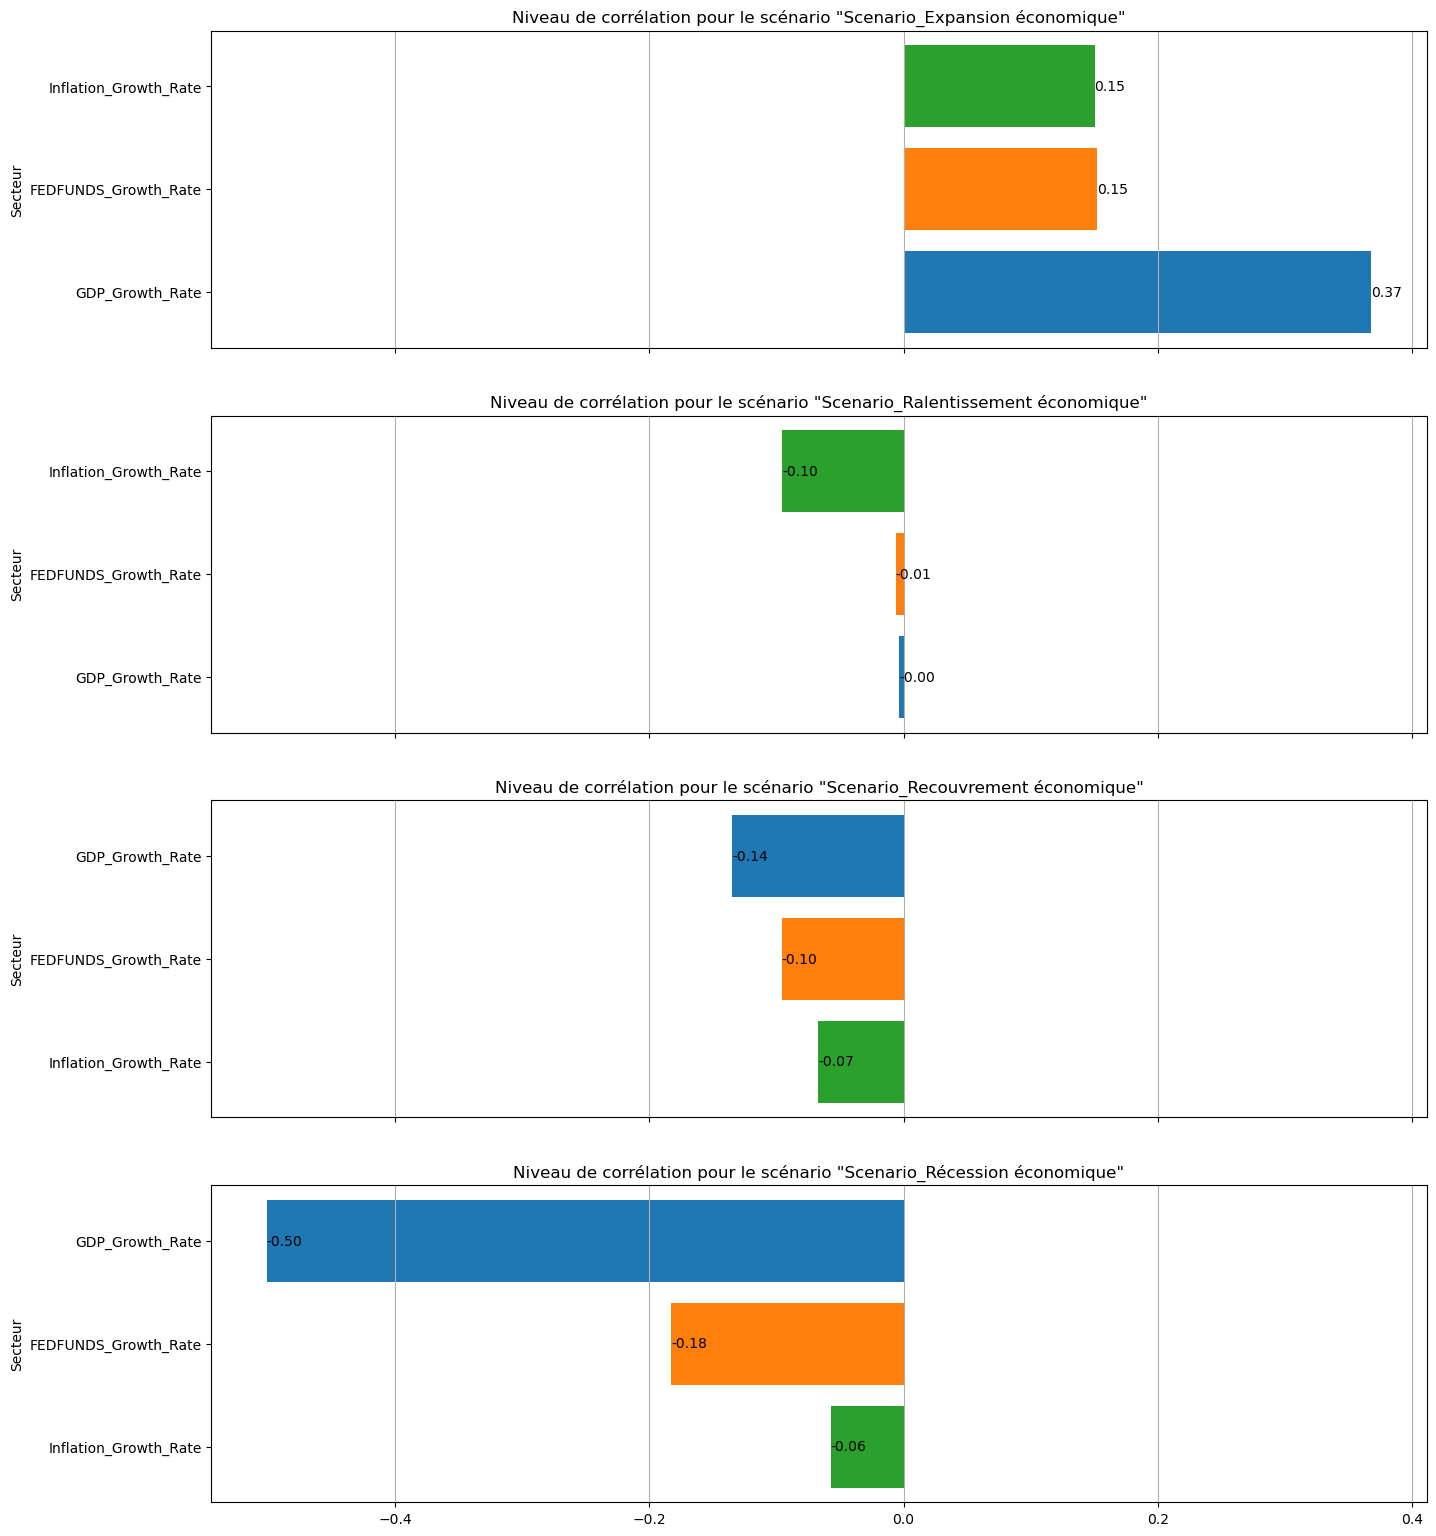

In [44]:
total_scenarios = len(correlation.columns)

sector_color_dict = {}
colors = plt.cm.tab10.colors[:len(correlation.index)]
for i, sector in enumerate(correlation.index):
    sector_color_dict[sector] = colors[i]

fig, axes = plt.subplots(total_scenarios, 1, figsize=(15, total_scenarios*4), sharex=True)

for i, scenario in enumerate(correlation.columns):
    sorted_sectors = correlation[scenario].sort_values(ascending=False)

    ax = axes[i]
    sectors = sorted_sectors.index
    scores = sorted_sectors.values

    colors = [sector_color_dict[sector] for sector in sectors]

    ax.barh(sectors, scores, color=colors)

    ax.set_ylabel('Secteur')
    ax.set_title(f'Niveau de corrélation pour le scénario "{scenario}"')
    ax.grid(axis='x')

    for j, score in enumerate(scores):
        ax.text(score, j, f'{score:.2f}', ha='left', va='center')

plt.tight_layout(pad=3.0)
plt.show()

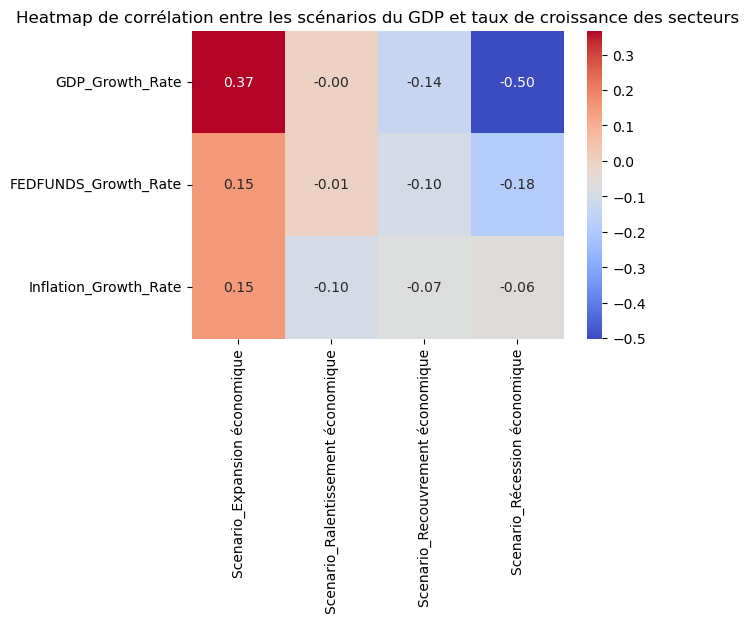

In [45]:
plt.figure(figsize=(6, 4))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap de corrélation entre les scénarios du GDP et taux de croissance des secteurs')
plt.show()

### Partie 4: Analyse du comportement du CPI et du GDP en fonction des scénarios de variabilité du FEDFUNDS

**Scénarios traités pour FEDFUNDS: Baisse importante des taux d'intérêt, Baisse légère des taux d'intérêt, Baisse générale des taux d'intérêt, Hausse importante des taux d'intérêt, Hausse modérée des taux d'intérêt, Maintien des taux d'intérêt et Hausse générale des taux d'intérêt**

In [46]:
def assign_scenario(row):
    FEDFUNDS_Growth_Rate = row['FEDFUNDS_Growth_Rate']
    Previous_FEDFUNDS_Growth_Rate = row['Previous_FEDFUNDS_Growth_Rate']

    scenario = ""

    if FEDFUNDS_Growth_Rate < Previous_FEDFUNDS_Growth_Rate:
        if FEDFUNDS_Growth_Rate < -1:
            scenario = "Baisse importante des taux d'intérêt"
        elif -1 <= FEDFUNDS_Growth_Rate < 0:
            scenario = "Baisse légère des taux d'intérêt"
        else:
            scenario = "Baisse générale des taux d'intérêt"
    elif FEDFUNDS_Growth_Rate > Previous_FEDFUNDS_Growth_Rate:
        if FEDFUNDS_Growth_Rate >= 3:
            scenario = "Hausse importante des taux d'intérêt"
        elif 1 <= FEDFUNDS_Growth_Rate < 3:
            scenario = "Hausse modérée des taux d'intérêt"
        elif 0 <= FEDFUNDS_Growth_Rate < 1:
            scenario = "Maintien des taux d'intérêt"
        else:
            scenario = "Hausse générale des taux d'intérêt"
    else:
        scenario = None
    return scenario

merged_data['Scenario'] = merged_data.apply(assign_scenario, axis=1)

scenario_data = merged_data[['date', 'Scenario']].dropna()
scenario_data

date                            Scenario
2   2000-07-01  Baisse générale des taux d'intérêt
3   2000-10-01    Baisse légère des taux d'intérêt
4   2001-01-01    Baisse légère des taux d'intérêt
5   2001-04-01    Baisse légère des taux d'intérêt
6   2001-07-01  Hausse générale des taux d'intérêt
..         ...                                 ...
96  2024-01-01  Baisse générale des taux d'intérêt
98  2024-07-01    Baisse légère des taux d'intérêt
99  2024-10-01    Baisse légère des taux d'intérêt
100 2025-01-01  Hausse générale des taux d'intérêt
101 2025-04-01         Maintien des taux d'intérêt

[99 rows x 2 columns]

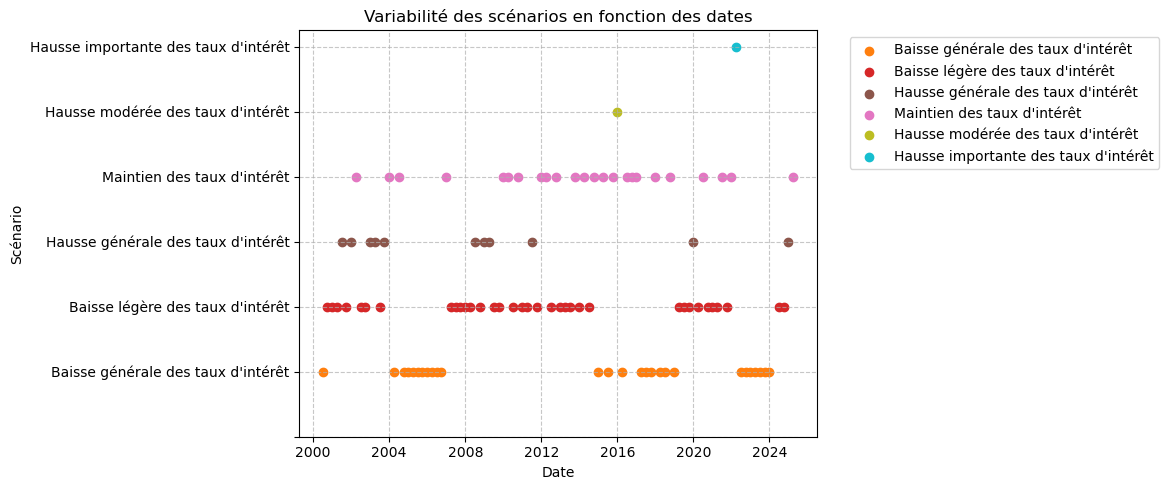

In [47]:
growth_rate = merged_data.drop(columns=['GDPC1', 'CPIAUCNS', 'FEDFUNDS', 'Previous_GDP_Growth_Rate', 'Previous_Inflation_Growth_Rate', 'Previous_FEDFUNDS_Growth_Rate'])

plt.figure(figsize=(12, 5))

unique_scenarios = growth_rate['Scenario'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_scenarios)))

for i, scenario in enumerate(unique_scenarios):
    scenario_data_subset = growth_rate[growth_rate['Scenario'] == scenario]
    plt.scatter(scenario_data_subset['date'], [i] * len(scenario_data_subset), color=colors[i], label=scenario)

plt.title('Variabilité des scénarios en fonction des dates')
plt.xlabel('Date')
plt.ylabel('Scénario')

plt.xticks(rotation=0, ha='center')

plt.yticks(np.arange(len(unique_scenarios)), unique_scenarios)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

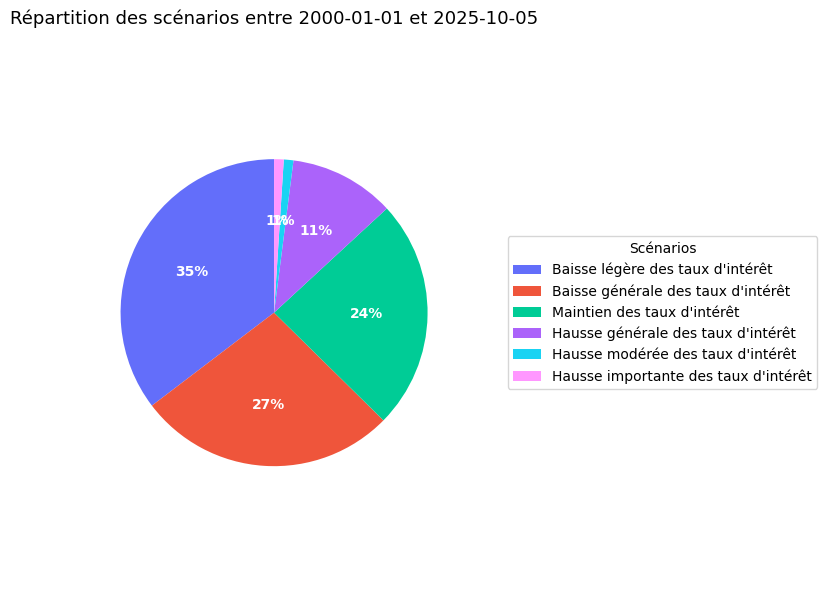

In [48]:
start_date = '2000-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

filtered_data = merged_data[
    (merged_data['date'] >= start_date) &
    (merged_data['date'] <= end_date)
]

scenario_counts = filtered_data['Scenario'].value_counts().reset_index()
scenario_counts.columns = ['Scenario', 'Count']

colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#19D3F3', '#FF97FF','#B6E880']

fig, ax = plt.subplots(figsize=(8, 6))

wedges, texts, autotexts = ax.pie(
    scenario_counts['Count'],
    labels=None,  
    autopct='%1.0f%%',
    startangle=90,
    colors=colors[:len(scenario_counts)],  
    textprops={'color': 'white', 'fontsize': 10, 'weight': 'bold'}
)

ax.legend(
    wedges,
    scenario_counts['Scenario'],
    title="Scénarios",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),
    fontsize=10
)

plt.title(f"Répartition des scénarios entre {start_date} et {end_date}", fontsize=13, pad=15)
ax.axis('equal')

plt.tight_layout()
plt.show()


In [49]:
merged_all_data_encoded = pd.get_dummies(scenario_data, columns=['Scenario'])

merged_all_data_encoded_no_date = merged_all_data_encoded.drop(columns='date')

growth_rate_reset = growth_rate.reset_index(drop=True)

final_data_for_corr = pd.concat(
    [merged_all_data_encoded_no_date,
     growth_rate_reset[['GDP_Growth_Rate', 'FEDFUNDS_Growth_Rate', 'Inflation_Growth_Rate']]],
    axis=1
)

correlation = final_data_for_corr.corr()

correlation = correlation.loc[
    ['GDP_Growth_Rate', 'FEDFUNDS_Growth_Rate', 'Inflation_Growth_Rate'],
    [col for col in correlation.columns if 'Scenario_' in col and 'Autres' not in col]
]

correlation

Scenario_Baisse générale des taux d'intérêt  \
GDP_Growth_Rate                                           0.073825   
FEDFUNDS_Growth_Rate                                      0.110219   
Inflation_Growth_Rate                                     0.041283   

                       Scenario_Baisse légère des taux d'intérêt  \
GDP_Growth_Rate                                        -0.105894   
FEDFUNDS_Growth_Rate                                   -0.324414   
Inflation_Growth_Rate                                  -0.050212   

                       Scenario_Hausse générale des taux d'intérêt  \
GDP_Growth_Rate                                          -0.155915   
FEDFUNDS_Growth_Rate                                     -0.138436   
Inflation_Growth_Rate                                    -0.061272   

                       Scenario_Hausse importante des taux d'intérêt  \
GDP_Growth_Rate                                            -0.029589   
FEDFUNDS_Growth_Rate                                        0.850360   
Inflation_Growth_Rate                                       0.317151   

                       Scenario_Hausse modérée des taux d'intérêt  \
GDP_Growth_Rate                                          0.004306   
FEDFUNDS_Growth_Rate                                     0.184491   
Inflation_Growth_Rate                                   -0.075979   

                       Scenario_Maintien des taux d'intérêt  
GDP_Growth_Rate                                    0.161645  
FEDFUNDS_Growth_Rate                               0.107410  
Inflation_Growth_Rate                              0.001770

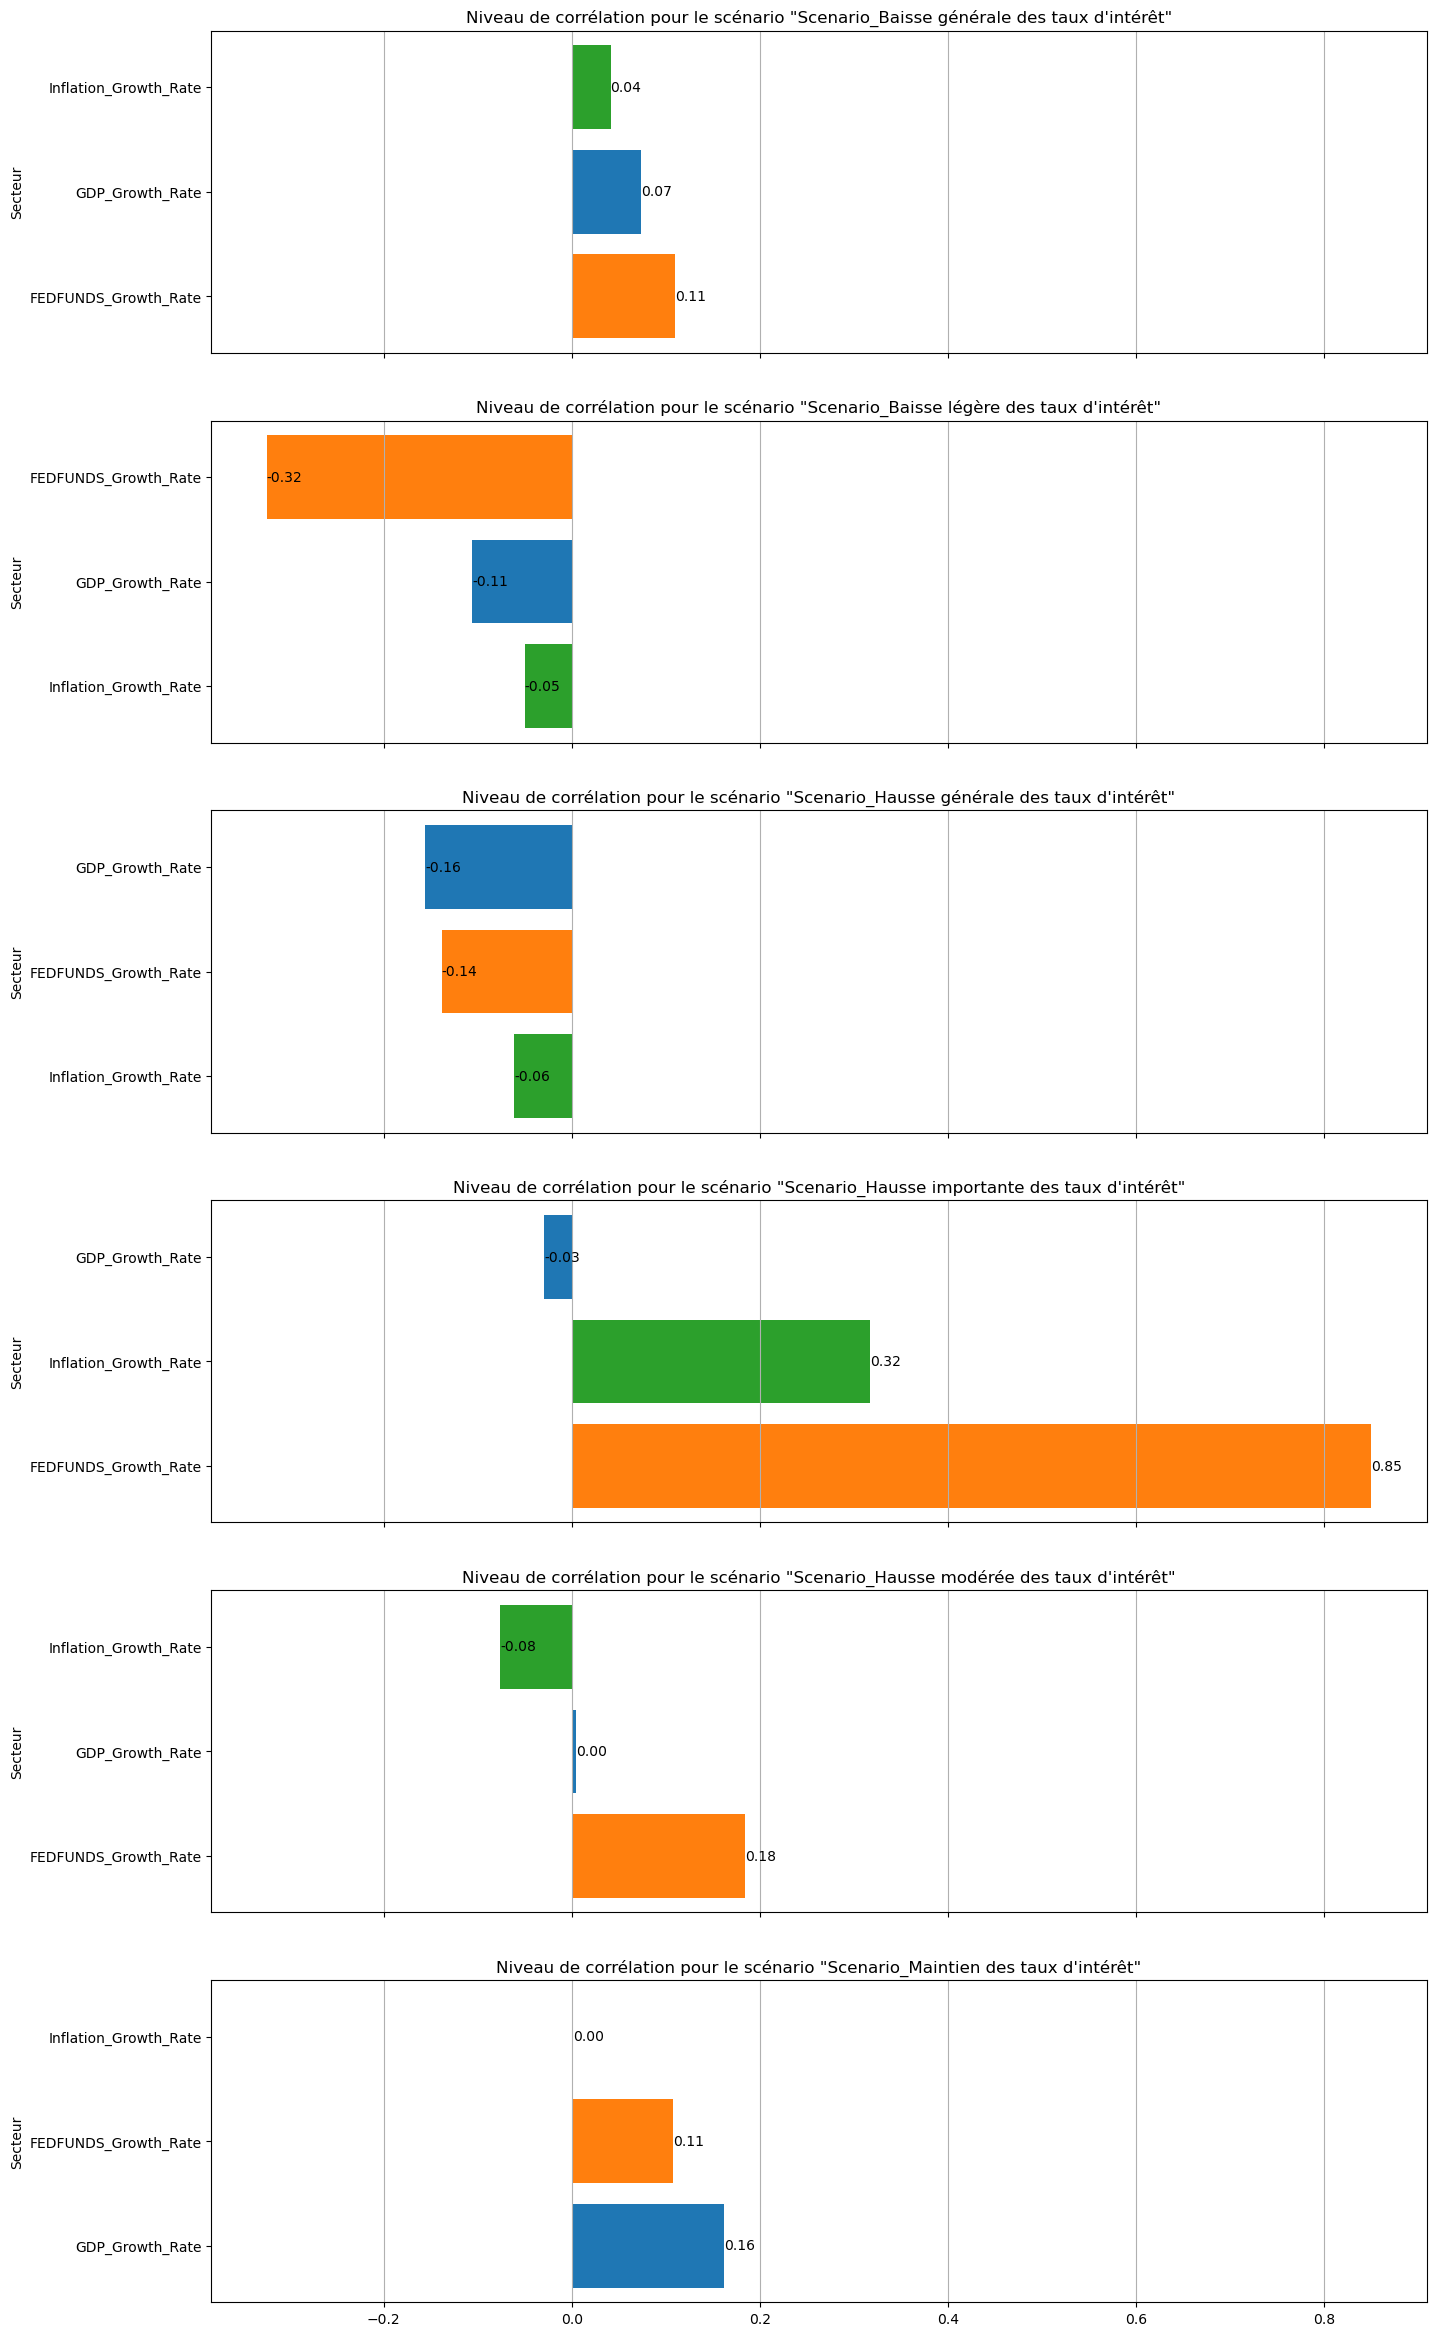

In [50]:
total_scenarios = len(correlation.columns)

sector_color_dict = {}
colors = plt.cm.tab10.colors[:len(correlation.index)]
for i, sector in enumerate(correlation.index):
    sector_color_dict[sector] = colors[i]

fig, axes = plt.subplots(total_scenarios, 1, figsize=(15, total_scenarios*4), sharex=True)

for i, scenario in enumerate(correlation.columns):
    sorted_sectors = correlation[scenario].sort_values(ascending=False)

    ax = axes[i]
    sectors = sorted_sectors.index
    scores = sorted_sectors.values

    colors = [sector_color_dict[sector] for sector in sectors]

    ax.barh(sectors, scores, color=colors)

    ax.set_ylabel('Secteur')
    ax.set_title(f'Niveau de corrélation pour le scénario "{scenario}"')
    ax.grid(axis='x')

    for j, score in enumerate(scores):
        ax.text(score, j, f'{score:.2f}', ha='left', va='center')

plt.tight_layout(pad=3.0)
plt.show()

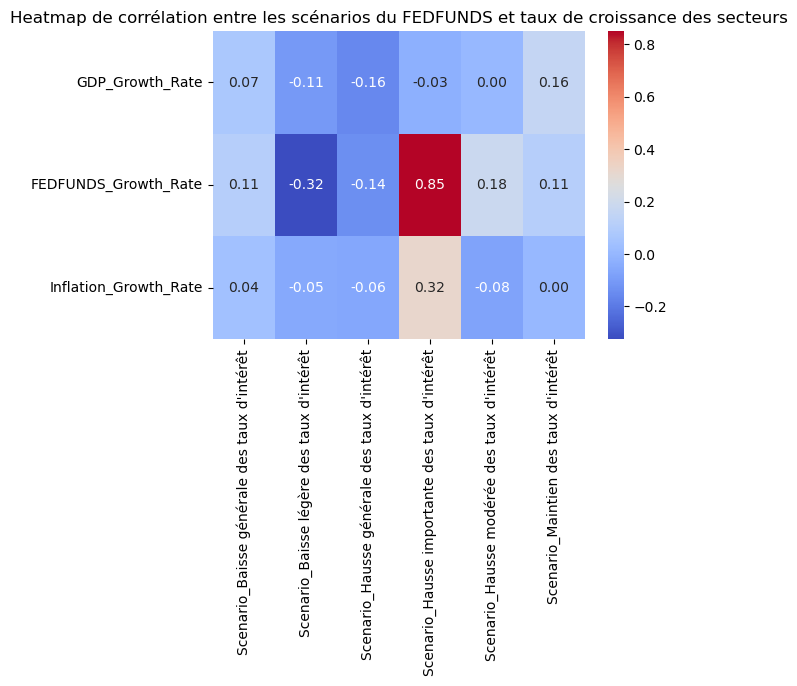

In [51]:
plt.figure(figsize=(6, 4))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap de corrélation entre les scénarios du FEDFUNDS et taux de croissance des secteurs')
plt.show()

### Partie 5: Analyse du comportement des secteurs économiques parraport à la variation des situations macroéconomiques

In [52]:
def assign_scenario(row):
    GDP_Growth_Rate = row['GDP_Growth_Rate']
    Previous_GDP_Growth_Rate = row['Previous_GDP_Growth_Rate']
    FEDFUNDS_Growth_Rate = row['FEDFUNDS_Growth_Rate']
    Previous_FEDFUNDS_Growth_Rate = row['Previous_FEDFUNDS_Growth_Rate']
    inflation_growth_rate = row['Inflation_Growth_Rate']
    previous_inflation_growth_rate = row['Previous_Inflation_Growth_Rate']

    scenario = ""

    if GDP_Growth_Rate > 0 and GDP_Growth_Rate > Previous_GDP_Growth_Rate:
        scenario += "Expansion économique. "
    elif GDP_Growth_Rate < 0 and GDP_Growth_Rate < Previous_GDP_Growth_Rate:
        scenario += "Récession économique. "
    elif GDP_Growth_Rate > 0 and GDP_Growth_Rate < Previous_GDP_Growth_Rate:
        scenario += "Ralentissement économique. "
    elif GDP_Growth_Rate < 0 and GDP_Growth_Rate > Previous_GDP_Growth_Rate:
        scenario += "Recouvrement économique. "

    if FEDFUNDS_Growth_Rate < Previous_FEDFUNDS_Growth_Rate:
        if FEDFUNDS_Growth_Rate < -1:
            scenario += "Baisse importante des taux d'intérêt. "
        elif -1 <= FEDFUNDS_Growth_Rate < 0:
            scenario += "Baisse légère des taux d'intérêt. "
        else:
            scenario += "Baisse générale des taux d'intérêt. "
    elif FEDFUNDS_Growth_Rate > Previous_FEDFUNDS_Growth_Rate:
        if FEDFUNDS_Growth_Rate >= 3:
            scenario += "Hausse importante des taux d'intérêt. "
        elif 1 <= FEDFUNDS_Growth_Rate < 3:
            scenario += "Hausse modérée des taux d'intérêt. "
        elif 0 <= FEDFUNDS_Growth_Rate < 1:
            scenario += "Maintien des taux d'intérêt. "
        else:
            scenario += "Hausse générale des taux d'intérêt. "

    if inflation_growth_rate >= 0.5:
        scenario += "Hyperinflation. "
    elif inflation_growth_rate < -0.02 and inflation_growth_rate < previous_inflation_growth_rate:
        scenario += "Déflation. "
    elif inflation_growth_rate > 0.05 and inflation_growth_rate > previous_inflation_growth_rate:
        scenario += "Stagflation. "
    elif 0.02 < inflation_growth_rate <= 0.05 and inflation_growth_rate > previous_inflation_growth_rate:
        scenario += "Inflation élevée. "
    elif -0.02 <= inflation_growth_rate <= 0.02 and inflation_growth_rate > previous_inflation_growth_rate:
        scenario += "Inflation modérée. "
    elif inflation_growth_rate < previous_inflation_growth_rate:
        scenario += "Désinflation. "
    elif inflation_growth_rate < -0.02 and inflation_growth_rate > previous_inflation_growth_rate:
        scenario += "Reprise après Déflation. "
    else:
        scenario = None
    return scenario

merged_data['Scenario'] = merged_data.apply(assign_scenario, axis=1)

scenario_data = merged_data[['date', 'Scenario']].dropna()
scenario_data

date                                           Scenario
2   2000-07-01  Ralentissement économique. Baisse générale des...
3   2000-10-01  Expansion économique. Baisse légère des taux d...
4   2001-01-01  Récession économique. Baisse légère des taux d...
5   2001-04-01  Expansion économique. Baisse légère des taux d...
6   2001-07-01  Récession économique. Hausse générale des taux...
..         ...                                                ...
97  2024-04-01          Expansion économique. Inflation modérée. 
98  2024-07-01  Ralentissement économique. Baisse légère des t...
99  2024-10-01  Ralentissement économique. Baisse légère des t...
100 2025-01-01  Récession économique. Hausse générale des taux...
101 2025-04-01  Expansion économique. Maintien des taux d'inté...

[100 rows x 2 columns]

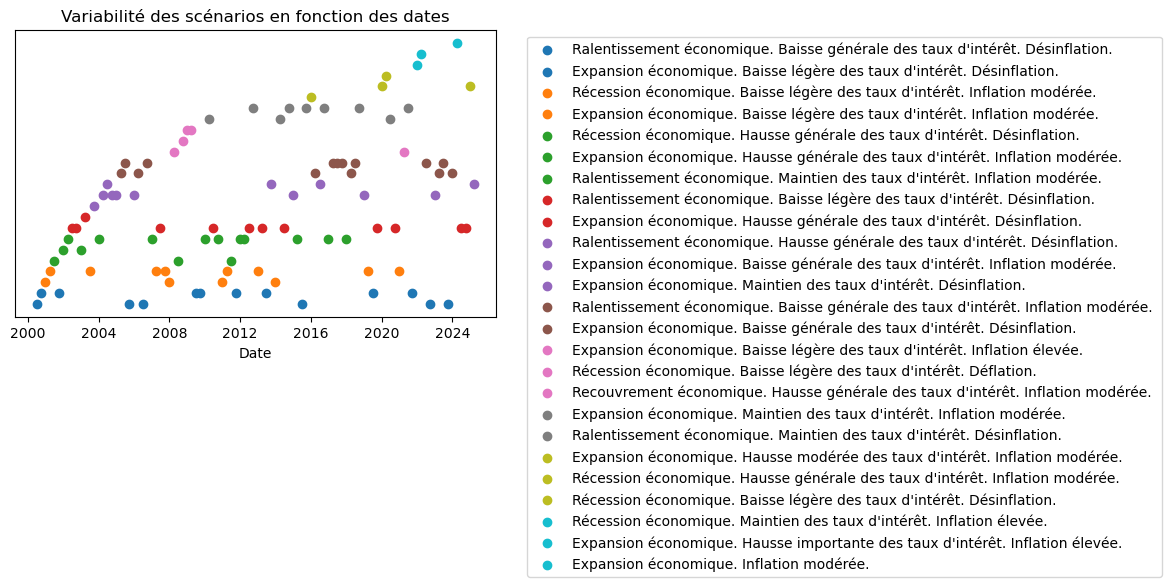

In [54]:
growth_rate = merged_data.drop(columns=['GDPC1', 'CPIAUCNS', 'FEDFUNDS', 'Previous_GDP_Growth_Rate', 'Previous_Inflation_Growth_Rate', 'Previous_FEDFUNDS_Growth_Rate'])

from matplotlib.colors import ListedColormap

plt.figure(figsize=(12, 5))

unique_scenarios = growth_rate['Scenario'].unique()
colors = plt.cm.get_cmap('tab10', len(unique_scenarios))

for i, scenario in enumerate(unique_scenarios):
    scenario_data_subset = growth_rate[growth_rate['Scenario'] == scenario]
    plt.scatter(scenario_data_subset['date'], [i] * len(scenario_data_subset), color=colors(i), label=scenario)

plt.title('Variabilité des scénarios en fonction des dates')
plt.xlabel('Date')
plt.ylabel('')

plt.xticks(rotation=0, ha='center')

plt.yticks([])

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

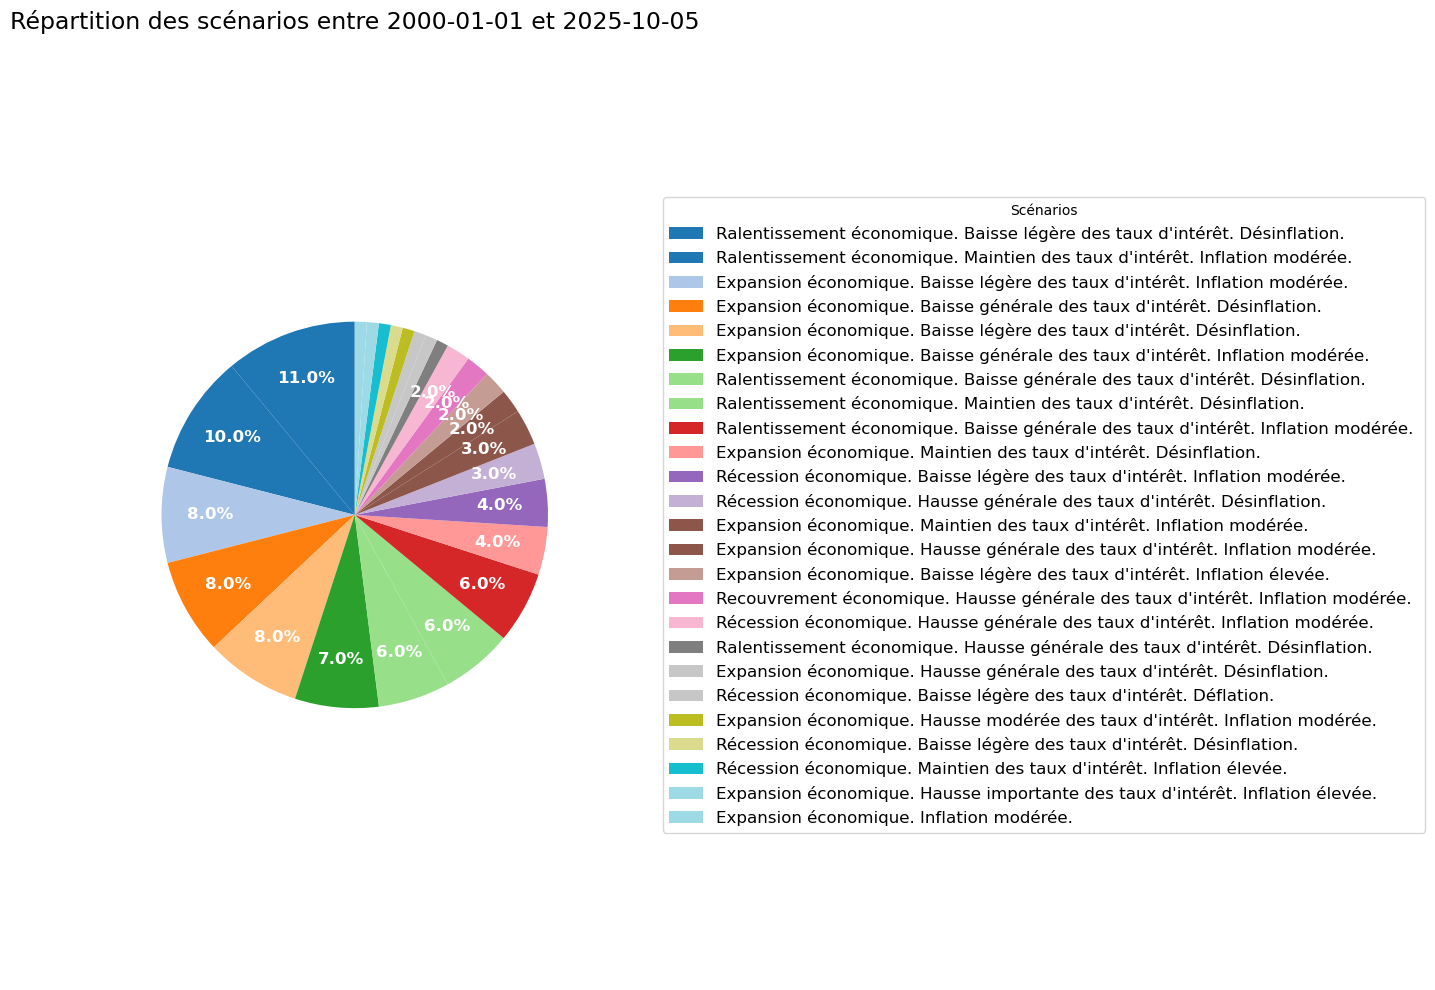

In [71]:

start_date = '2000-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

filtered_data = merged_data[
    (merged_data['date'] >= start_date) &
    (merged_data['date'] <= end_date)
]

scenario_counts = filtered_data['Scenario'].value_counts().reset_index() 
scenario_counts.columns = ['Scenario', 'Count']

n = len(scenario_counts)
colors = cm.tab20(np.linspace(0, 1, n))

fig, ax = plt.subplots(figsize=(14, 10))  
wedges, texts, autotexts = ax.pie(
    scenario_counts['Count'],
    labels=None,
    autopct=lambda pct: ('%1.1f%%' % pct) if pct > 1 else '',  
    startangle=90,
    colors=colors,
    textprops={'color': 'white', 'fontsize': 12, 'weight': 'bold'},
    pctdistance=0.75,   
    radius=1.3   
)

ax.legend(
    wedges,
    scenario_counts['Scenario'],
    title="Scénarios",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),
    fontsize=12
)

plt.title(f"Répartition des scénarios entre {start_date} et {end_date}", fontsize=17, pad=15)

ax.axis('equal')

plt.tight_layout()
plt.show()


In [ ]:
api_key = '8e877013bcb3862ac90cd864024bdb75'
fred = Fred(api_key=api_key)

series_codes = {
    'Manufacturing Production': 'INDPRO',
    'Retail Sales': 'RSXFS',
    'Construction Spending': 'CPIAUCSL',
    'Consumer Expenditures': 'PCE',
    'Energy Prices': 'MCOILWTICO',
    'Food Prices': 'CPIFABSL',
    'Housing Prices': 'CSUSHPINSA'
}

data_dict = {}
for sector, code in series_codes.items():
    data = fred.get_series(code)
    data = data.loc['2000-01-01':'2025-12-31']
    data_dict[sector] = data

secteurs_data = pd.DataFrame(data_dict)

secteurs_data.reset_index(inplace=True)
secteurs_data.rename(columns={'index': 'date'}, inplace=True)

secteurs_data['date'] = pd.to_datetime(secteurs_data['date'])
secteurs_data['Quarter'] = secteurs_data['date'].dt.to_period('Q')

secteurs_data_quarterly = secteurs_data.groupby('Quarter').mean().reset_index()

premiere_dates_trimestre = secteurs_data.groupby('Quarter')['date'].first().reset_index()

secteurs_data_quarterly['date'] = premiere_dates_trimestre['date']

secteurs_data_quarterly.drop(columns=['Quarter'], inplace=True)

cols = ['date'] + [col for col in secteurs_data_quarterly.columns if col != 'date']
secteurs_data_quarterly = secteurs_data_quarterly[cols]

secteurs_data_quarterly

date  Manufacturing Production   Retail Sales  \
0   2000-01-01                 91.738900  241205.000000   
1   2000-04-01                 92.867467  241441.333333   
2   2000-07-01                 92.803667  242939.000000   
3   2000-10-01                 92.548700  244363.000000   
4   2001-01-01                 91.411467  246380.666667   
..         ...                       ...            ...   
98  2024-07-01                102.711400  606078.000000   
99  2024-10-01                102.402933  617266.333333   
100 2025-01-01                103.430600  619269.333333   
101 2025-04-01                103.830300  621901.333333   
102 2025-07-01                103.869850  630555.000000   

     Construction Spending  Consumer Expenditures  Energy Prices  Food Prices  \
0               170.100000            6618.233333      28.823333   166.633333   
1               171.433333            6711.900000      28.776667   167.666667   
2               173.000000            6819.966667      31.613333   169.166667   
3               174.233333            6918.600000      31.990000   169.933333   
4               175.900000            6995.300000      28.816667   171.600000   
..                     ...                    ...            ...          ...   
98              314.182667           20032.800000      76.240000   328.232333   
99              316.538667           20351.300000      70.686667   330.753333   
100             319.492000           20555.000000      71.836667   333.716333   
101             320.800333           20789.933333      64.626667   335.553333   
102             322.748000           21047.300000      66.625000   337.501500   

     Housing Prices  
0        100.679000  
1        103.699000  
2        106.461000  
3        108.271000  
4        109.751333  
..              ...  
98       325.171333  
99       323.735333  
100      325.525000  
101      331.009333  
102      331.127000  

[103 rows x 8 columns]

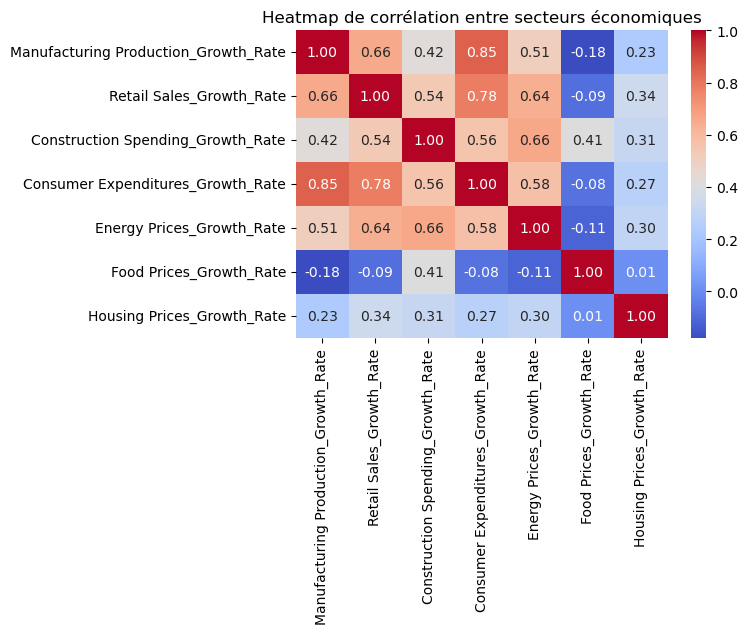

In [ ]:
colonnes_secteurs = ['Manufacturing Production', 'Retail Sales', 'Construction Spending', 'Consumer Expenditures', 'Energy Prices', 'Food Prices', 'Housing Prices']

for colonne in colonnes_secteurs:
    nom_colonne_taux_croissance = colonne + '_Growth_Rate'
    secteurs_data_quarterly[nom_colonne_taux_croissance] = secteurs_data_quarterly[colonne].pct_change() * 100

growth_rate_secteur=secteurs_data_quarterly[['date'] + [colonne + '_Growth_Rate' for colonne in colonnes_secteurs]]

correlation_matrix = growth_rate_secteur[['Manufacturing Production_Growth_Rate', 'Retail Sales_Growth_Rate', 'Construction Spending_Growth_Rate', 'Consumer Expenditures_Growth_Rate', 'Energy Prices_Growth_Rate', 'Food Prices_Growth_Rate', 'Housing Prices_Growth_Rate']].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap de corrélation entre secteurs économiques')
plt.show()

In [87]:
merged_all_data = pd.merge(growth_rate, growth_rate_secteur, on='date')
merged_all_data = merged_all_data.dropna().reset_index(drop=True)
merged_all_data

date  GDP_Growth_Rate  Inflation_Growth_Rate  FEDFUNDS_Growth_Rate  \
0  2000-07-01         0.001019               0.007958              0.039320   
1  2000-10-01         0.005970               0.005392             -0.007157   
2  2001-01-01        -0.003278               0.009577             -0.135942   
3  2001-04-01         0.006245               0.010434             -0.226460   
4  2001-07-01        -0.004006               0.001314             -0.191834   
..        ...              ...                    ...                   ...   
95 2024-04-01         0.008855               0.011510              0.000000   
96 2024-07-01         0.008248               0.003021             -0.012508   
97 2024-10-01         0.004599               0.002250             -0.116529   
98 2025-01-01        -0.001625               0.010341             -0.068817   
99 2025-04-01         0.009460               0.008645              0.000000   

                                             Scenario  \
0   Ralentissement économique. Baisse générale des...   
1   Expansion économique. Baisse légère des taux d...   
2   Récession économique. Baisse légère des taux d...   
3   Expansion économique. Baisse légère des taux d...   
4   Récession économique. Hausse générale des taux...   
..                                                ...   
95          Expansion économique. Inflation modérée.    
96  Ralentissement économique. Baisse légère des t...   
97  Ralentissement économique. Baisse légère des t...   
98  Récession économique. Hausse générale des taux...   
99  Expansion économique. Maintien des taux d'inté...   

    Manufacturing Production_Growth_Rate  Retail Sales_Growth_Rate  \
0                              -0.068700                  0.620303   
1                              -0.274738                  0.586155   
2                              -1.228794                  0.825684   
3                              -1.259579                  1.225340   
4                              -1.371260                 -1.088347   
..                                   ...                       ...   
95                              0.606922                  1.007132   
96                             -0.147672                  1.236451   
97                             -0.300324                  1.846022   
98                              1.003552                  0.324495   
99                              0.386443                  0.425017   

    Construction Spending_Growth_Rate  Consumer Expenditures_Growth_Rate  \
0                            0.913864                           1.610076   
1                            0.712909                           1.446244   
2                            0.956572                           1.108606   
3                            0.701156                           0.670927   
4                            0.282273                           0.399021   
..                                ...                                ...   
95                           0.682157                           1.605648   
96                           0.347178                           1.400751   
97                           0.749882                           1.589893   
98                           0.933009                           1.000919   
99                           0.409504                           1.142950   

    Energy Prices_Growth_Rate  Food Prices_Growth_Rate  \
0                    9.857523                 0.894632   
1                    1.191480                 0.453202   
2                   -9.919767                 0.980777   
3                   -3.157895                 0.815851   
4                   -4.443383                 0.828516   
..                        ...                      ...   
95                   5.354994                 0.361679   
96                  -6.698213                 0.555729   
97                  -7.284015                 0.768054   
98                   1.626898            

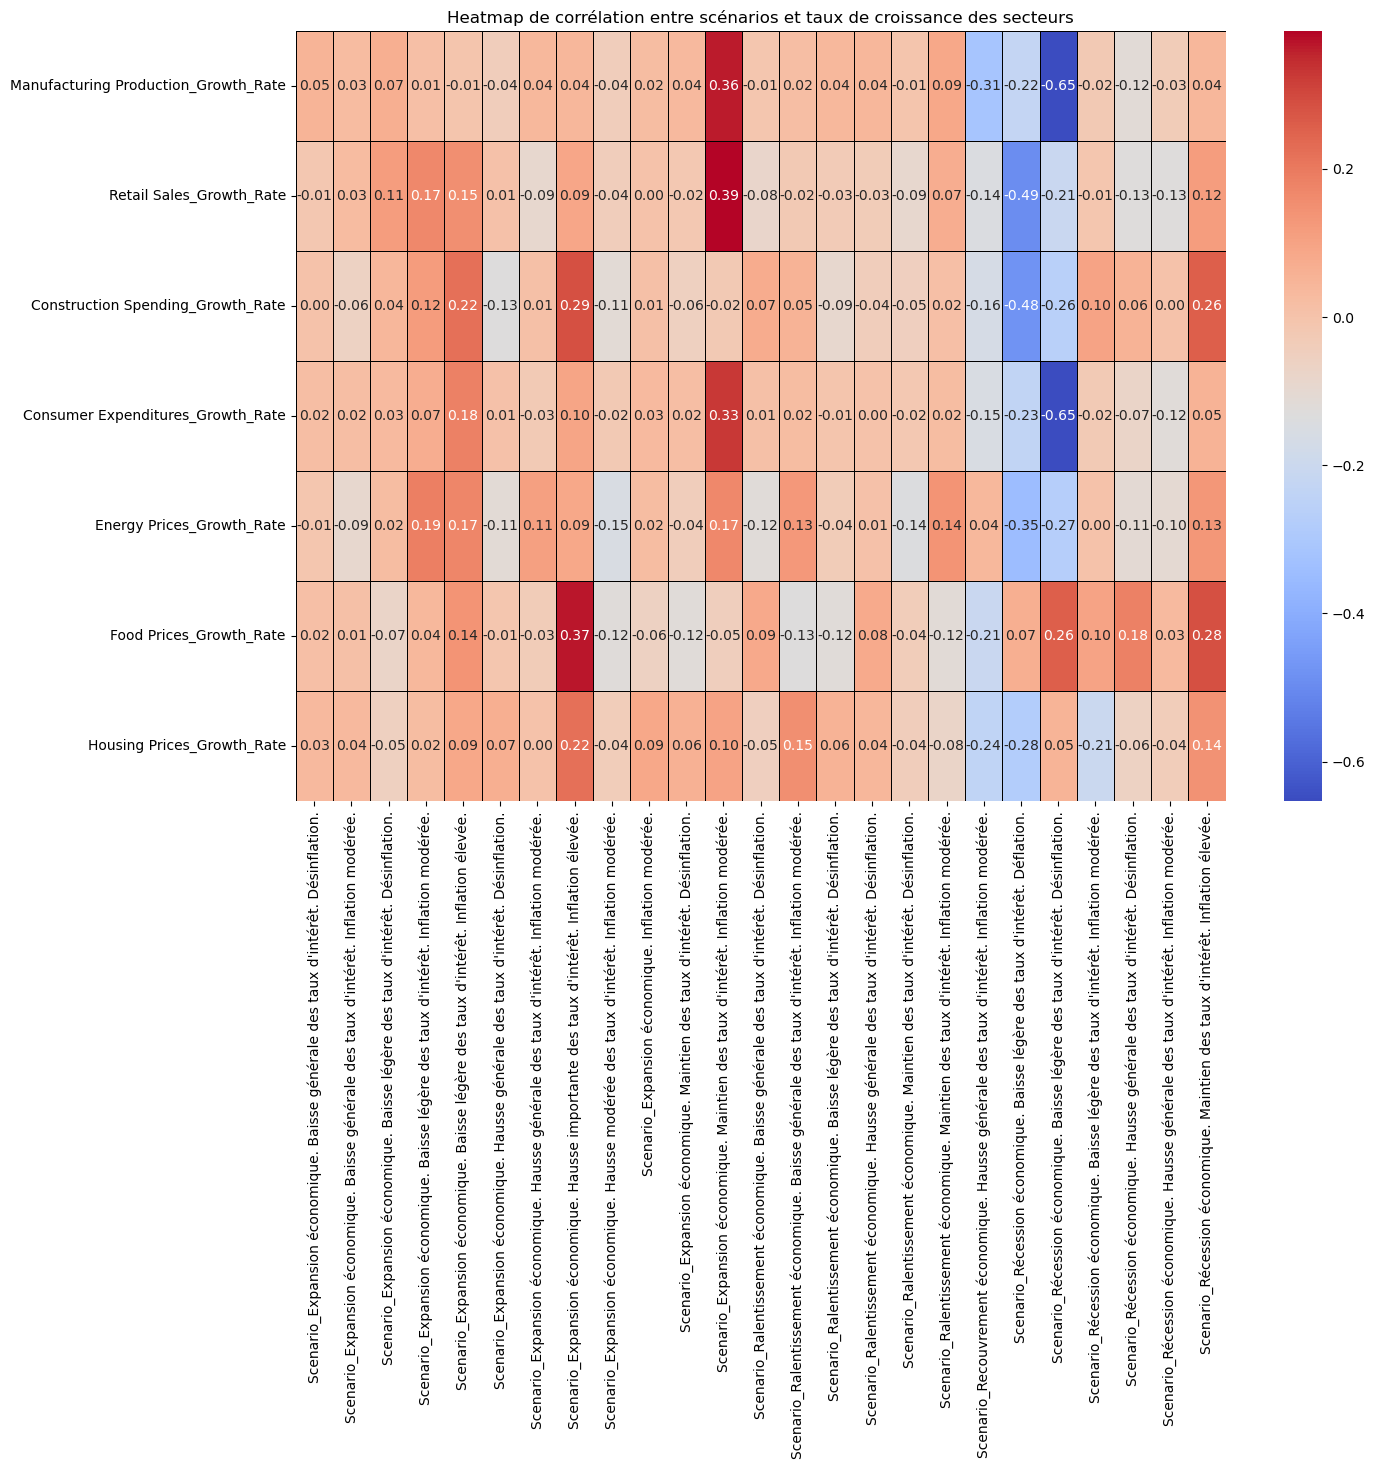

In [88]:
merged_all_data_encoded = pd.get_dummies(merged_all_data, columns=['Scenario'])
merged_all_data_encoded.columns = merged_all_data_encoded.columns.str.strip()

scenario_columns = [col for col in merged_all_data_encoded.columns if col.startswith('Scenario_')]

growth_rate_columns = [
    'Manufacturing Production_Growth_Rate',
    'Retail Sales_Growth_Rate',
    'Construction Spending_Growth_Rate',
    'Consumer Expenditures_Growth_Rate',
    'Energy Prices_Growth_Rate',
    'Food Prices_Growth_Rate',
    'Housing Prices_Growth_Rate'
]

columns_for_corr = scenario_columns + growth_rate_columns

existing_columns_for_corr = [col for col in columns_for_corr if col in merged_all_data_encoded.columns]
correlation = merged_all_data_encoded[existing_columns_for_corr].corr()
correlation = correlation.loc[growth_rate_columns, scenario_columns]

plt.figure(figsize=(15, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linecolor='black', linewidths=0.5)
plt.title('Heatmap de corrélation entre scénarios et taux de croissance des secteurs')
plt.show()


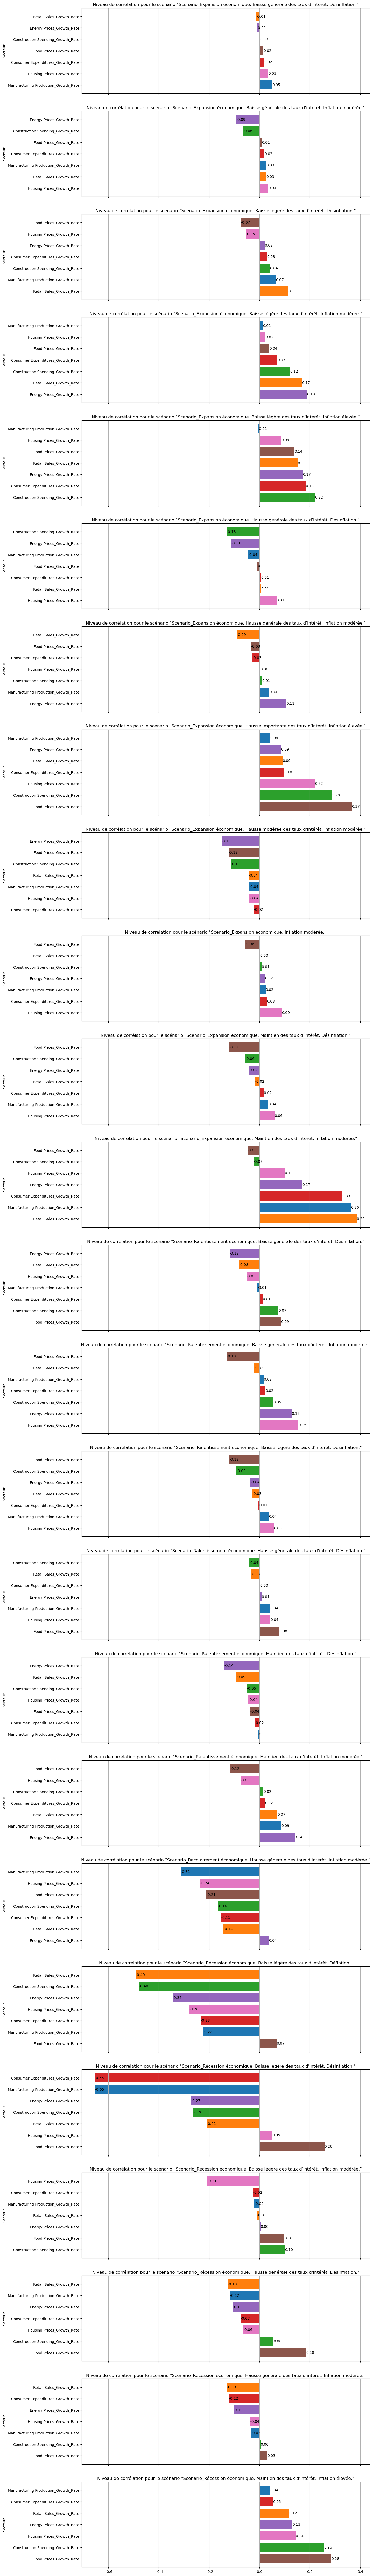

In [89]:
total_scenarios = len(correlation.columns)

sector_color_dict = {}
colors = plt.cm.tab10.colors[:len(correlation.index)]
for i, sector in enumerate(correlation.index):
    sector_color_dict[sector] = colors[i]

fig, axes = plt.subplots(total_scenarios, 1, figsize=(15, total_scenarios*4), sharex=True)

for i, scenario in enumerate(correlation.columns):
    sorted_sectors = correlation[scenario].sort_values(ascending=False)

    ax = axes[i]
    sectors = sorted_sectors.index
    scores = sorted_sectors.values

    colors = [sector_color_dict[sector] for sector in sectors]

    ax.barh(sectors, scores, color=colors)

    ax.set_ylabel('Secteur')
    ax.set_title(f'Niveau de corrélation pour le scénario "{scenario}"')
    ax.grid(axis='x')

    for j, score in enumerate(scores):
        ax.text(score, j, f'{score:.2f}', ha='left', va='center')

plt.tight_layout(pad=3.0)
plt.show()

### Partie 6: Analyse du comportement des ETFs sectoriels parraport à chaque situation macroéconomique

In [91]:
etf_symbols = ['XLI', 'XLB', 'XLE', 'XLP', 'XLY', 'XLF', 'XLK', 'XLU', 'XLV', 'ITB']

start_date = '2000-01-01'
end_date = '2023-12-31'

def get_etf_data(etf_symbol):
    etf = yf.download(etf_symbol, start=start_date, end=end_date)
    return etf

etf_data = pd.DataFrame()

for symbol in etf_symbols:
    etf = get_etf_data(symbol)
    etf_data[symbol] = etf['Close']

etf_data = etf_data.astype(float)

etf_data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


XLI        XLB        XLE        XLP         XLY  \
Date                                                                  
2000-01-03   18.187740  14.595759  13.513032  12.305084   22.391146   
2000-01-04   17.685270  14.455250  13.258664  11.958583   21.717556   
2000-01-05   17.606445  15.052429  13.608406  12.169867   21.450443   
2000-01-06   17.842899  15.438835  14.133039  12.398045   21.694338   
2000-01-07   18.522728  15.430059  14.284064  13.184015   22.716341   
...                ...        ...        ...        ...         ...   
2023-12-22  110.336266  82.857407  80.272064  67.972275  176.823029   
2023-12-26  111.116508  83.244583  80.961617  68.258591  177.571777   
2023-12-27  111.282310  83.447861  80.602669  68.573540  178.182617   
2023-12-28  111.311562  83.128441  79.374687  68.602158  177.256516   
2023-12-29  111.175026  82.799332  79.195221  68.745331  176.162949   

                  XLF         XLK        XLU         XLV         ITB  
Date                                                                  
2000-01-03  11.186878   41.366707  11.186378   20.612175         NaN  
2000-01-04  10.697840   39.268055  10.848943   20.144440         NaN  
2000-01-05  10.613779   38.685108  11.122716   19.963730         NaN  
2000-01-06  11.079898   37.402588  11.103614   20.027521         NaN  
2000-01-07  11.263290   38.055496  11.199114   20.272017         NaN  
...               ...         ...        ...         ...         ...  
2023-12-22  36.384628  189.848557  59.449173  131.168243   99.480690  
2023-12-26  36.530792  190.639389  59.809937  131.459702  100.020050  
2023-12-27  36.647717  190.629486  59.771965  132.013428  100.490799  
2023-12-28  36.754902  190.856842  60.199177  132.353439  100.167168  
2023-12-29  36.637981  190.273621  60.123226  132.489441   99.765091  

[6037 rows x 10 columns]

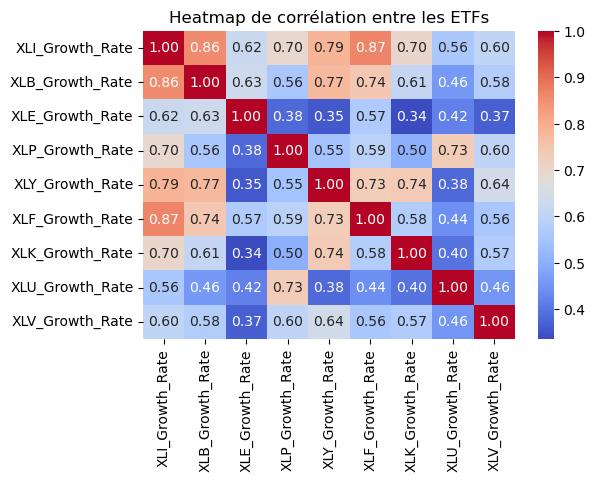

In [92]:
etf_data.reset_index(inplace=True)
etf_data.head()

etf_data['date'] = pd.to_datetime(etf_data['Date'])

etf_data['Quarter'] = etf_data['date'].dt.to_period('Q')

etf_data_quarterly = etf_data.groupby('Quarter').mean().reset_index()

premiere_dates_trimestre = etf_data.groupby('Quarter')['date'].first().reset_index()

etf_data_quarterly['date'] = premiere_dates_trimestre['date']

etf_data_quarterly = etf_data_quarterly.reindex(columns=['date', 'XLI', 'XLB', 'XLE',	'XLP', 'XLY',	'XLF',	'XLK',	'XLU',	'XLV'])

colonnes_secteurs = ['XLI', 'XLB', 'XLE',	'XLP', 'XLY',	'XLF',	'XLK',	'XLU',	'XLV'	]
for colonne in colonnes_secteurs:
    nom_colonne_taux_croissance = colonne + '_Growth_Rate'
    etf_data_quarterly[nom_colonne_taux_croissance] = etf_data_quarterly[colonne].pct_change() * 100

growth_rate_etf=etf_data_quarterly[['date'] + [colonne + '_Growth_Rate' for colonne in colonnes_secteurs]]

colonnes_secteurs = ['XLI_Growth_Rate', 'XLB_Growth_Rate',	'XLE_Growth_Rate',	'XLP_Growth_Rate',	'XLY_Growth_Rate',	'XLF_Growth_Rate',	'XLK_Growth_Rate',	'XLU_Growth_Rate',	'XLV_Growth_Rate']
variabilite_etf = etf_data_quarterly[['date'] + colonnes_secteurs].copy()

correlation_matrix_etf = growth_rate_etf[['XLI_Growth_Rate', 'XLB_Growth_Rate',	'XLE_Growth_Rate',	'XLP_Growth_Rate',	'XLY_Growth_Rate',	'XLF_Growth_Rate',	'XLK_Growth_Rate',	'XLU_Growth_Rate',	'XLV_Growth_Rate']].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix_etf, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap de corrélation entre les ETFs')
plt.show()

In [94]:
merged_all_data_etf = pd.merge(growth_rate, growth_rate_etf, on='date')
merged_all_data_etf

date  GDP_Growth_Rate  Inflation_Growth_Rate  FEDFUNDS_Growth_Rate  \
0  2001-10-01         0.002748              -0.002813             -0.389895   
1  2002-04-01         0.006127               0.010868              0.009615   
2  2002-07-01         0.004065               0.004263             -0.005714   
3  2002-10-01         0.001236               0.003138             -0.170498   
4  2003-04-01         0.008856               0.003643             -0.002667   
5  2003-07-01         0.016632               0.004900             -0.184492   
6  2003-10-01         0.011607               0.000181             -0.019672   
7  2004-04-01         0.007750               0.014316              0.006645   
8  2004-07-01         0.009486               0.003529              0.419142   
9  2004-10-01         0.010202               0.005977              0.360465   
10 2005-04-01         0.004926               0.013373              0.191633   
11 2005-07-01         0.007838               0.012168              0.175538   
12 2007-10-01         0.006282               0.007112             -0.113666   
13 2008-04-01         0.005954               0.021953             -0.343127   
14 2008-07-01        -0.005253               0.011631             -0.070288   
15 2008-10-01        -0.021890              -0.028285             -0.738832   
16 2009-04-01        -0.001787               0.010603             -0.018182   
17 2009-07-01         0.003512               0.006791             -0.129630   
18 2009-10-01         0.010809               0.002012             -0.234043   
19 2010-04-01         0.009676               0.004751              0.450000   
20 2010-07-01         0.007711               0.000933             -0.034483   
21 2010-10-01         0.005251               0.002949              0.000000   
22 2011-04-01         0.006766               0.017433             -0.404255   
23 2011-07-01        -0.000223               0.004085             -0.107143   
24 2012-10-01         0.001156               0.000360              0.116279   
25 2013-04-01         0.002676               0.005410             -0.186047   
26 2013-07-01         0.008514               0.003780             -0.285714   
27 2013-10-01         0.008717              -0.002791              0.040000   
28 2014-04-01         0.012918               0.011809              0.272727   
29 2014-07-01         0.012154               0.001147             -0.035714   
30 2014-10-01         0.005057              -0.008034              0.111111   
31 2015-04-01         0.006194               0.012056              0.121212   
32 2015-07-01         0.004002               0.002627              0.108108   
33 2015-10-01         0.001845              -0.004498              0.170732   
34 2016-04-01         0.003211               0.011724              0.037037   
35 2016-07-01         0.007094               0.003327              0.062500   
36 2018-10-01         0.001416              -0.000575              0.154246   
37 2019-04-01         0.008351               0.011985             -0.002774   
38 2019-07-01         0.011700               0.002742             -0.086231   
39 2019-10-01         0.006819               0.002130             -0.249619   
40 2020-04-01        -0.078768              -0.005400             -0.952381   
41 2020-07-01         0.077623               0.011315              0.555556   
42 2020-10-01         0.011335               0.002300             -0.035714   
43 2021-04-01         0.017019               0.023398             -0.125000   
44 2021-07-01         0.008251               0.016010              0.285714   
45 2021-10-01         0.017158               0.015178             -0.111111   
46 2022-04-01         0.001565               0.029738              5.416667   
47 2022-07-01         0.007219               0.013147              1.844156   

                                             Scenario  XLI_Growth_Rate  \
0   Expansion économique. Baisse légère des taux d...        -5

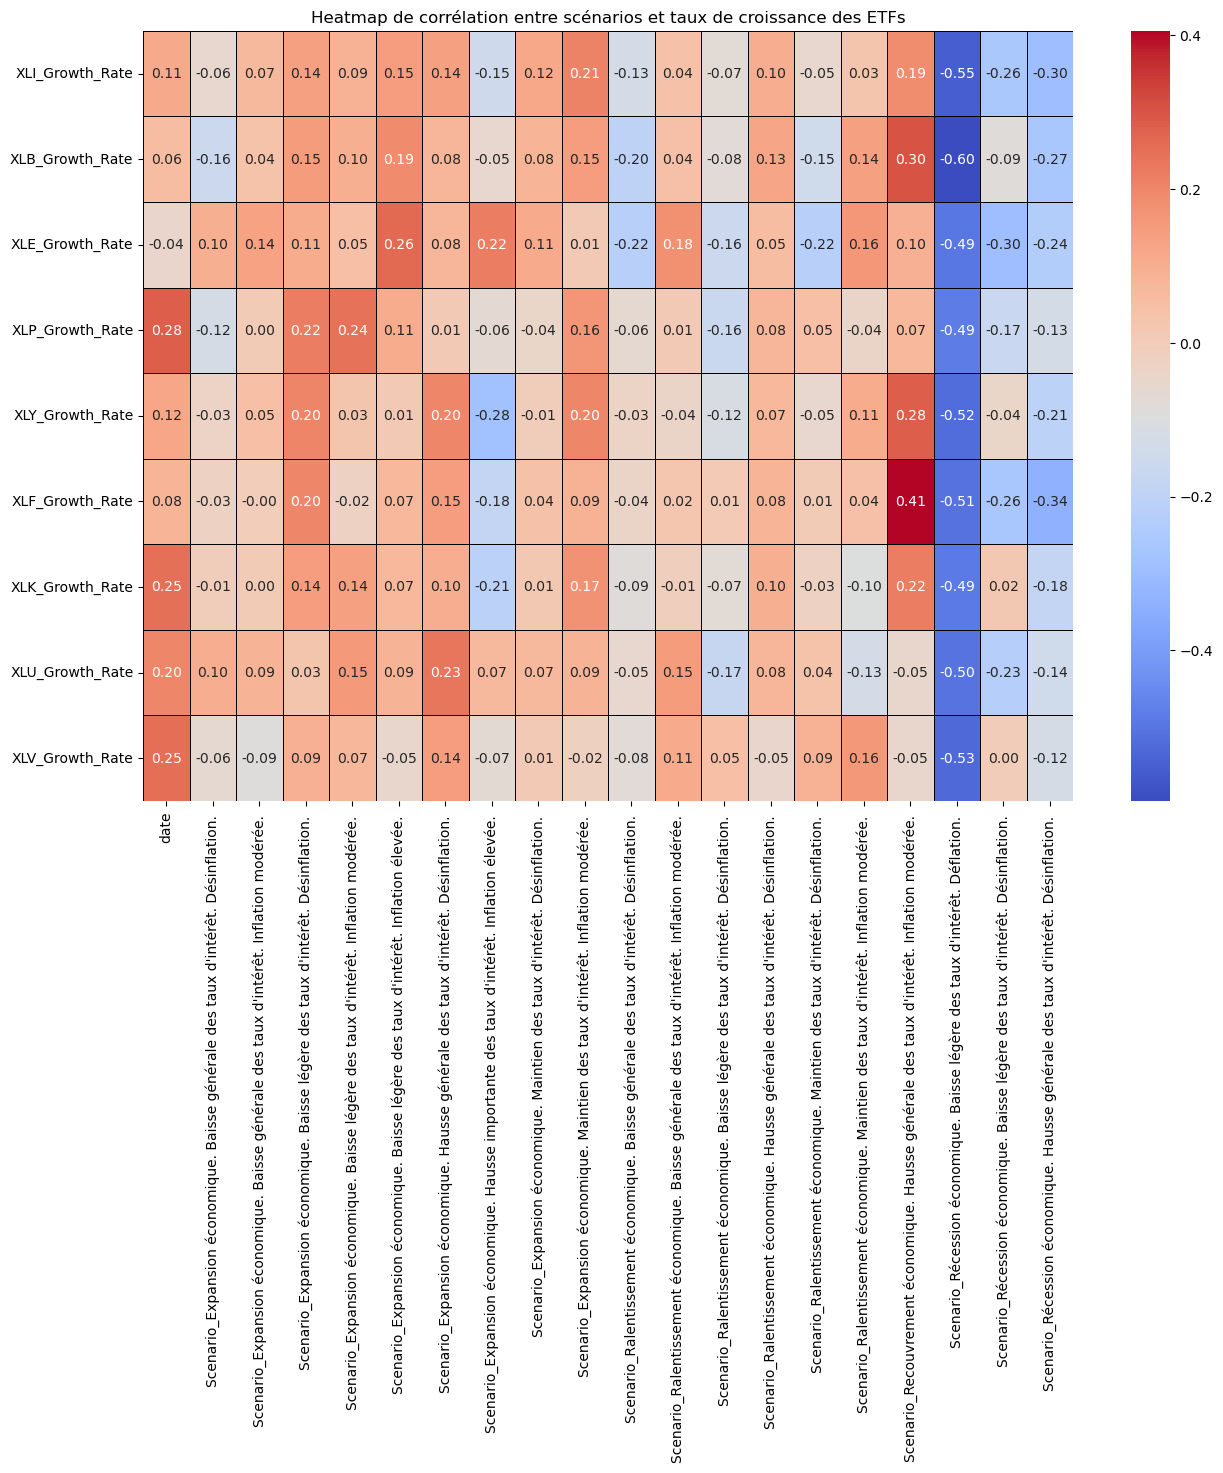

In [ ]:
merged_all_data_encoded = pd.get_dummies(merged_all_data_etf, columns=['Scenario'])

correlation_etf = merged_all_data_encoded.corr()

correlation_etf.drop(columns=['GDP_Growth_Rate','Inflation_Growth_Rate','FEDFUNDS_Growth_Rate', 'XLI_Growth_Rate',
                               'XLB_Growth_Rate',
                               'XLE_Growth_Rate',
                               'XLP_Growth_Rate',
                               'XLY_Growth_Rate',
                               'XLF_Growth_Rate',
                               'XLK_Growth_Rate',
                               'XLU_Growth_Rate',
                               'XLV_Growth_Rate'], inplace=True)

sectors_to_keep = ['XLI_Growth_Rate', 'XLB_Growth_Rate', 'XLE_Growth_Rate','XLP_Growth_Rate', 'XLY_Growth_Rate', 'XLF_Growth_Rate',
                   'XLK_Growth_Rate', 'XLU_Growth_Rate', 'XLV_Growth_Rate']

correlation_etf = correlation_etf.loc[sectors_to_keep]

plt.figure(figsize=(15, 10))
sns.heatmap(correlation_etf, annot=True, cmap='coolwarm', fmt=".2f", linecolor='black', linewidths=0.5)
plt.title('Heatmap de corrélation entre scénarios et taux de croissance des ETFs')
plt.show()

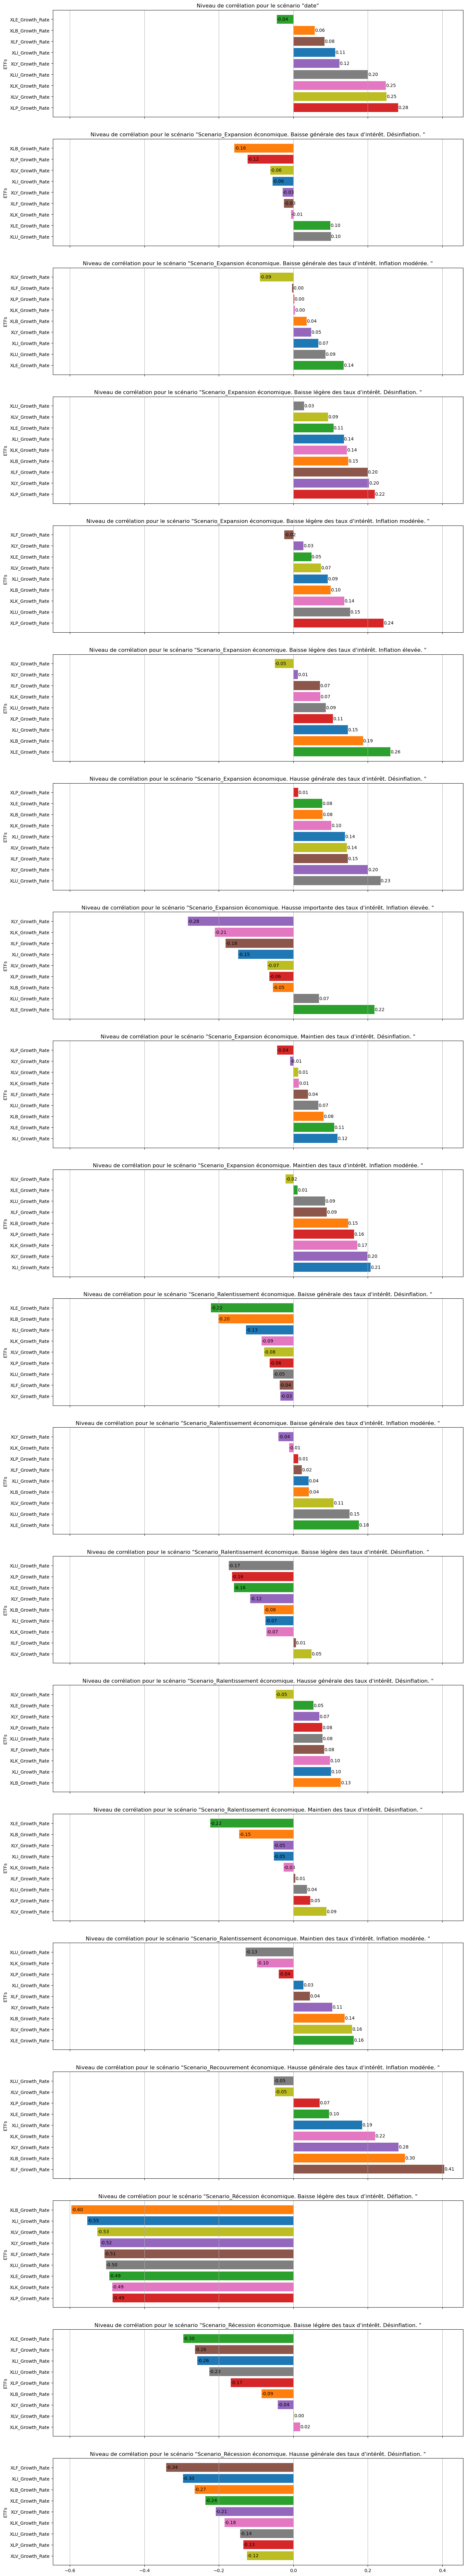

In [95]:
total_scenarios = len(correlation_etf.columns)

sector_color_dict = {}
colors = plt.cm.tab10.colors[:len(correlation_etf.index)]
for i, sector in enumerate(correlation_etf.index):
    sector_color_dict[sector] = colors[i]

fig, axes = plt.subplots(total_scenarios, 1, figsize=(15, total_scenarios*4), sharex=True)

for i, scenario in enumerate(correlation_etf.columns):
    sorted_sectors = correlation_etf[scenario].sort_values(ascending=False)

    ax = axes[i]
    sectors = sorted_sectors.index
    scores = sorted_sectors.values

    colors = [sector_color_dict[sector] for sector in sectors]

    ax.barh(sectors, scores, color=colors)

    ax.set_ylabel('ETFs')
    ax.set_title(f'Niveau de corrélation pour le scénario "{scenario}"')
    ax.grid(axis='x')

    for j, score in enumerate(scores):
        ax.text(score, j, f'{score:.2f}', ha='left', va='center')

plt.tight_layout(pad=3.0)
plt.show()